# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [799]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost

In [800]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn para treinamento da rede neural
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# 1. Coleta de dados

Dataset de https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [801]:
import os

if not os.path.exists('./data/student-dropout.zip'):
    !curl -L -o ./data/student-dropout.zip 'https://www.kaggle.com/api/v1/datasets/download/thedevastator/higher-education-predictors-of-student-retention'
    !unzip ./data/student-dropout.zip -d ./data
else:
    print("File already exists. Skipping download.")

File already exists. Skipping download.


In [802]:
data = pd.read_csv("./data/dataset.csv")

# 2. Análise Exploratória dos Dados

O objetivo é entender melhor e sumarizar as características dos dados, analisando quantidade e tipos de atributos, verificando distribuição do atributo alvo, identificando padrões e anomalias, removendo atributos que pareçam irrelevantes ou problemáticos, etc. Utilize gráficos e sumarizações estatísticas para a EDA. Verifique potenciais problemas nos dados, como por exemplo, a necessidade de normalizar os atributos, balancear classes, ou remover instâncias ou atributos por inconsistências nos dados.

Objetivo: compreender como as variáveis do dataset se relacionam com a probabilidade de desistência da universidade.

- P1. Qual a quantidade e tipos de atributos? Existem inconsistências?
  - Quais são os atributos disponíveis? Dentre eles, quais são os categóricos, e quais são os numéricos?
  - Existem inconsistências nos atributos? (Atributos vazios, potenciais erros, etc)
  - Existem atributos que necessitam ser removidos ou transformados?
- P2. Qual a distribuição do atributo alvo?
  - Quais são as classes alvo? Qual a distribuição entre as classes? Está balanceada ou desbalanceada?
- P3. Quais os padrões e anomalias dos atributos individuais?
  - Quais as relações entre as variávies numéricas e categóricas?
- P4. Quais os padrões e anomalias entre todos os atributos?
  - Qual o range dos atributos numéricos? Eles necessitam ser normalizados?




## P1. Qual a quantidade e tipos de atributos?

**Quantidade de atributos**

In [803]:
data.info(verbose = False, memory_usage = False, show_counts = True) # mostra o tipo e a quantidade de itens não nulos de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Columns: 35 entries, Marital status to Target
dtypes: float64(5), int64(29), object(1)

Existem 35 atributos, onde um é o atributo alvo ('Target') e os outros 34 são potenciais atributos treináveis.

In [804]:
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


**Tipos de atributos**

In [805]:
data.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance                          int64
Previous qualification                              int64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender                                              int64
Scholarship holder                                  int64
Age at enrollm

O atributo alvo é codificado como tipo object, o que significa um ponteiro que aponta para strings. 

Os 34 atributos potencialmente treináveis estão codificados como atributos numéricos float64 ou int64. Todavia, pela descrição do conjunto de dados, alguns destes parâmetros são categóricos e foram codificados para int64.

Isto dificulta a interpreteação dos gráficos e análise entre atributos categóricos e numéricos. Para isto, reconstruímos os atributos categóricos em um novo DataFrame através das informações do data descriptor deste dataset [[1](https://doi.org/10.3390/data7110146)] 

Como nosso objetivo de aprendizado é separar os dados entre evasão e permanência, este último que pode ser matriculado (enrolled) ou graduado (graduated), juntamos estas labels através destas traduções/localizações.

In [806]:
data['Target'].head()

0     Dropout
1    Graduate
2     Dropout
3    Graduate
4    Graduate
Name: Target, dtype: object

In [807]:
data['Target'] = data['Target'].map({
    'Dropout': 'Evasão',
    'Enrolled': 'Permanência',
    'Graduate': 'Permanência'
})

data['Target'].head()

0         Evasão
1    Permanência
2         Evasão
3    Permanência
4    Permanência
Name: Target, dtype: object

Em primeiro lugar, separamos manualmente, com base no descritor, o nome dos atributos em duas listas.

In [808]:
categorical_nominal = ['Application mode', 'Course', 'Previous qualification', 'Nacionality',
       "Mother's qualification", "Father's qualification",
       "Mother's occupation", "Father's occupation"]

categorical_binary = ['Marital status', 'Daytime/evening attendance', 'Displaced', 'Gender', 'International', 'Educational special needs',
                      'Debtor', 'Tuition fees up to date', 'Scholarship holder', 'Target']

categorical_data = categorical_nominal + categorical_binary

numerical_data = ['Application order', 'Curricular units 1st sem (credited)',
       'Curricular units 1st sem (enrolled)',
       'Curricular units 1st sem (evaluations)',
       'Curricular units 1st sem (approved)',
       'Curricular units 1st sem (grade)',
       'Curricular units 1st sem (without evaluations)',
       'Curricular units 2nd sem (credited)',
       'Curricular units 2nd sem (enrolled)',
       'Curricular units 2nd sem (evaluations)',
       'Curricular units 2nd sem (approved)',
       'Curricular units 2nd sem (grade)',
       'Curricular units 2nd sem (without evaluations)', 'Unemployment rate',
       'Inflation rate', 'GDP', 'Age at enrollment']


print(len(categorical_nominal) + len(categorical_binary) + len(numerical_data))

35


In [809]:
data[numerical_data].head()

,Application order,Curricular units 1st sem (credited),Curricular units 1st sem (enrolled),Curricular units 1st sem (evaluations),Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 1st sem (without evaluations),Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Age at enrollment
0,5,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,20
1,1,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,19
2,5,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,19
3,2,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,20
4,1,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,45


Criamos um dicionário dos dados categóricos, a partir do descritor do conjunto de dados [1] e com auxílio do Github Copilot para acelerar a transcrição.

In [810]:
# Dicionário de dados

data_cat = data.copy(deep=True)

data_cat['Marital status'] = data['Marital status'].map({
    1: 'Single',
    2: 'Married',
    3: 'Widower',
    4: 'Divorced',
    5: 'Facto union',
    6: 'Legally separated'
})

data_cat['Nacionality'] = data['Nacionality'].map({
    1: 'Portuguese',
    2: 'German',
    3: 'Spanish',
    4: 'Italian',
    5: 'Dutch',
    6: 'English',
    7: 'Lithuanian',
    8: 'Angolan',
    9: 'Cape Verdean',
    10: 'Guinean',
    11: 'Mozambican',
    12: 'Santomean',
    13: 'Turkish',
    14: 'Brazilian',
    15: 'Romanian',
    16: 'Moldova (Republic of)',
    17: 'Mexican',
    18: 'Ukrainian',
    19: 'Russian',
    20: 'Cuban',
    21: 'Colombian'
})

data_cat['Application mode'] = data['Application mode'].map({
    1: '1st phase—general contingent',
    2: 'Ordinance No. 612/93',
    3: '1st phase—special contingent (Azores Island)',
    4: 'Holders of other higher courses',
    5: 'Ordinance No. 854-B/99',
    6: 'International student (bachelor)',
    7: '1st phase—special contingent (Madeira Island)',
    8: '2nd phase—general contingent',
    9: '3rd phase—general contingent',
    10: 'Ordinance No. 533-A/99, item b2) (Different Plan)',
    11: 'Ordinance No. 533-A/99, item b3 (Other Institution)',
    12: 'Over 23 years old',
    13: 'Transfer',
    14: 'Change in course',
    15: 'Technological specialization diploma holders',
    16: 'Change in institution/course',
    17: 'Short cycle diploma holders',
    18: 'Change in institution/course (International)'
})

data_cat['Course'] = data['Course'].map({
    1: 'Biofuel Production Technologies',
    2: 'Animation and Multimedia Design',
    3: 'Social Service (evening attendance)',
    4: 'Agronomy',
    5: 'Communication Design',
    6: 'Veterinary Nursing',
    7: 'Informatics Engineering',
    8: 'Equiniculture',
    9: 'Management',
    10: 'Social Service',
    11: 'Tourism',
    12: 'Nursing',
    13: 'Oral Hygiene',
    14: 'Advertising and Marketing Management',
    15: 'Journalism and Communication',
    16: 'Basic Education',
    17: 'Management (evening attendance)'
})

data_cat['Previous qualification'] = data['Previous qualification'].map({
    1: 'Secondary education',
    2: 'Higher education—bachelor’s degree',
    3: 'Higher education—degree',
    4: 'Higher education—master’s degree',
    5: 'Higher education—doctorate',
    6: 'Frequency of higher education',
    7: '12th year of schooling—not completed',
    8: '11th year of schooling—not completed',
    9: 'Other—11th year of schooling',
    10: '10th year of schooling',
    11: '10th year of schooling—not completed',
    12: 'Basic education 3rd cycle (9th/10th/11th year) or equivalent',
    13: 'Basic education 2nd cycle (6th/7th/8th year) or equivalent',
    14: 'Technological specialization course',
    15: 'Higher education—degree (1st cycle)',
    16: 'Professional higher technical course',
    17: 'Higher education—master’s degree (2nd cycle)'
})

parents_qualification_mapping = {
    1: 'Secondary Education—12th Year of Schooling or Equivalent',
    2: 'Higher Education—bachelor’s degree',
    3: 'Higher Education—degree',
    4: 'Higher Education—master’s degree',
    5: 'Higher Education—doctorate',
    6: 'Frequency of Higher Education',
    7: '12th Year of Schooling—not completed',
    8: '11th Year of Schooling—not completed',
    9: '7th Year (Old)',
    10: 'Other—11th Year of Schooling',
    11: '2nd year complementary high school course',
    12: '10th Year of Schooling',
    13: 'General commerce course',
    14: 'Basic Education 3rd Cycle (9th/10th/11th Year) or Equivalent',
    15: 'Complementary High School Course',
    16: 'Technical-professional course',
    17: 'Complementary High School Course—not concluded',
    18: '7th year of schooling',
    19: '2nd cycle of the general high school course',
    20: '9th Year of Schooling—not completed',
    21: '8th year of schooling',
    22: 'General Course of Administration and Commerce',
    23: 'Supplementary Accounting and Administration',
    24: 'Unknown',
    25: 'Cannot read or write',
    26: 'Can read without having a 4th year of schooling',
    27: 'Basic education 1st cycle (4th/5th year) or equivalent',
    28: 'Basic Education 2nd Cycle (6th/7th/8th Year) or equivalent',
    29: 'Technological specialization course',
    30: 'Higher education—degree (1st cycle)',
    31: 'Specialized higher studies course',
    32: 'Professional higher technical course',
    33: 'Higher Education—master’s degree (2nd cycle)',
    34: 'Higher Education—doctorate (3rd cycle)'
}

data_cat["Mother's qualification"] = data["Mother's qualification"].map(parents_qualification_mapping)
data_cat["Father's qualification"] = data["Father's qualification"].map(parents_qualification_mapping)

parents_occupation_mapping = {
    1: 'Student',
    2: 'Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers',
    3: 'Specialists in Intellectual and Scientific Activities',
    4: 'Intermediate Level Technicians and Professions',
    5: 'Administrative staff',
    6: 'Personal Services, Security and Safety Workers, and Sellers',
    7: 'Farmers and Skilled Workers in Agriculture, Fisheries, and Forestry',
    8: 'Skilled Workers in Industry, Construction, and Craftsmen',
    9: 'Installation and Machine Operators and Assembly Workers',
    10: 'Unskilled Workers',
    11: 'Armed Forces Professions',
    12: 'Other Situation',
    13: '(blank)',
    14: 'Armed Forces Officers',
    15: 'Armed Forces Sergeants',
    16: 'Other Armed Forces personnel',
    17: 'Directors of administrative and commercial services',
    18: 'Hotel, catering, trade, and other services directors',
    19: 'Specialists in the physical sciences, mathematics, engineering, and related techniques',
    20: 'Health professionals',
    21: 'Teachers',
    22: 'Specialists in finance, accounting, administrative organization, and public and commercial relations',
    23: 'Intermediate level science and engineering technicians and professions',
    24: 'Technicians and professionals of intermediate level of health',
    25: 'Intermediate level technicians from legal, social, sports, cultural, and similar services',
    26: 'Information and communication technology technicians',
    27: 'Office workers, secretaries in general, and data processing operators',
    28: 'Data, accounting, statistical, financial services, and registry-related operators',
    29: 'Other administrative support staff',
    30: 'Personal service workers',
    31: 'Sellers',
    32: 'Personal care workers and the like',
    33: 'Protection and security services personnel',
    34: 'Market-oriented farmers and skilled agricultural and animal production workers',
    35: 'Farmers, livestock keepers, fishermen, hunters and gatherers, and subsistence',
    36: 'Skilled construction workers and the like, except electricians',
    37: 'Skilled workers in metallurgy, metalworking, and similar',
    38: 'Skilled workers in electricity and electronics',
    39: 'Workers in food processing, woodworking, and clothing and other industries and crafts',
    40: 'Fixed plant and machine operators',
    41: 'Assembly workers',
    42: 'Vehicle drivers and mobile equipment operators',
    43: 'Unskilled workers in agriculture, animal production, and fisheries and forestry',
    44: 'Unskilled workers in extractive industry, construction, manufacturing, and transport',
    45: 'Meal preparation assistants',
    46: 'Street vendors (except food) and street service providers'
}

data_cat["Mother's occupation"] = data["Mother's occupation"].map(parents_occupation_mapping)
data_cat["Father's occupation"] = data["Father's occupation"].map(parents_occupation_mapping)

data_cat['Gender'] = data['Gender'].map({
    1: 'male',
    0: 'female'
})

data_cat['Daytime/evening attendance'] = data['Daytime/evening attendance'].map({
    1: 'daytime',
    0: 'evening'
})

binary_mapping = {
    'Displaced': {1: 'yes', 0: 'no'},
    'Educational special needs': {1: 'yes', 0: 'no'},
    'Debtor': {1: 'yes', 0: 'no'},
    'Tuition fees up to date': {1: 'yes', 0: 'no'},
    'Scholarship holder': {1: 'yes', 0: 'no'},
    'International': {1: 'yes', 0: 'no'}
}

for column, mapping in binary_mapping.items():
    data_cat[f'{column}'] = data[column].map(mapping)

data_cat['Target'] = data['Target'].copy()

In [811]:
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 35 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   object 
 1   Application mode                                4424 non-null   object 
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   object 
 4   Daytime/evening attendance                      4424 non-null   object 
 5   Previous qualification                          4424 non-null   object 
 6   Nacionality                                     4424 non-null   object 
 7   Mother's qualification                          4424 non-null   object 
 8   Father's qualification                          4424 non-null   object 
 9   Mother's occupation                      

**Quantidade de atributos categóricos e numéricos**

In [812]:
# Contar a quantidade de atributos categóricos e numéricos
num_categorical = len(data_cat.select_dtypes(include=['object']).columns)
num_numerical = len(data_cat.select_dtypes(include=['number']).columns)

print(f"Quantidade de atributos categóricos: {num_categorical}")
print(f"Quantidade de atributos numéricos: {num_numerical}")

Quantidade de atributos categóricos: 18
Quantidade de atributos numéricos: 17


## P2. Qual a distribuição do atributo alvo?

In [813]:
print(data["Target"].unique())

['Evasão' 'Permanência']


In [814]:
data['Target'].describe(include='all')

count            4424
unique              2
top       Permanência
freq             3003
Name: Target, dtype: object

Percentual de frequência das classes do atributo alvo

In [815]:
series = data['Target'].value_counts(normalize=True)
print(series)


Target
Permanência    0.678797
Evasão         0.321203
Name: proportion, dtype: float64


<Axes: xlabel='Target', ylabel='count'>

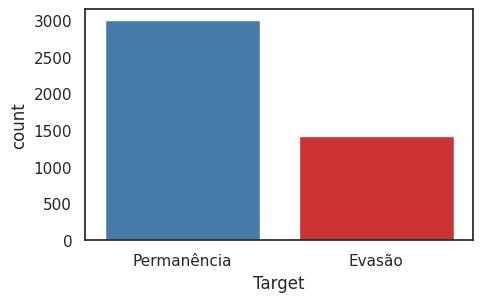

In [816]:
fig = plt.figure(figsize=(5, 3))

sns.countplot(x = data['Target'], data = data, hue='Target', legend=False, palette='Set1',
                order=data['Target'].value_counts().index)

Existe um **desbalanceamento nas classes do atributo alvo**. A classe 'Graduate', que representa os estudantes formados, tem 31,9% mais instâncias do que 'Enrolled', que representa os estudantes com o curso em andamento.

**Possibilidade de ação**: escolher um método de amostragem para balancear as classes do atributo alvo.

## P3. Quais os padrões e anomalias dos atributos individuais?

### Atributos numéricos - univariados

Gráficos
- Histograma: distribuição de frequência
- Boxplot

Estatísticas descritivas univariadas
- Média (sensível a outliers)
- Mediana (menos sensível a outliers)
- Desvio padrão
- Mínimo e máximo
- Intervalo
- Quartil (Q1, Q2, Intervalo Interquartil, Limites Superior e Inferior)
- Assimetria
- Curtose
- Dados vazios

Application order

Média : 1.73
Mediana : 1.0
Variância : 1.73
Desvio padrão : 1.31
Min : 0
Max : 9
Intervalo:  9
Amostras únicas : 8
Amostras faltando : 0
Q1 : 1.0
Q3 : 2.0
IQR : 1.0
Limite inferior : -0.5
Limite superior : 3.5
Obliquidade : 1.88
Curtose : 2.65


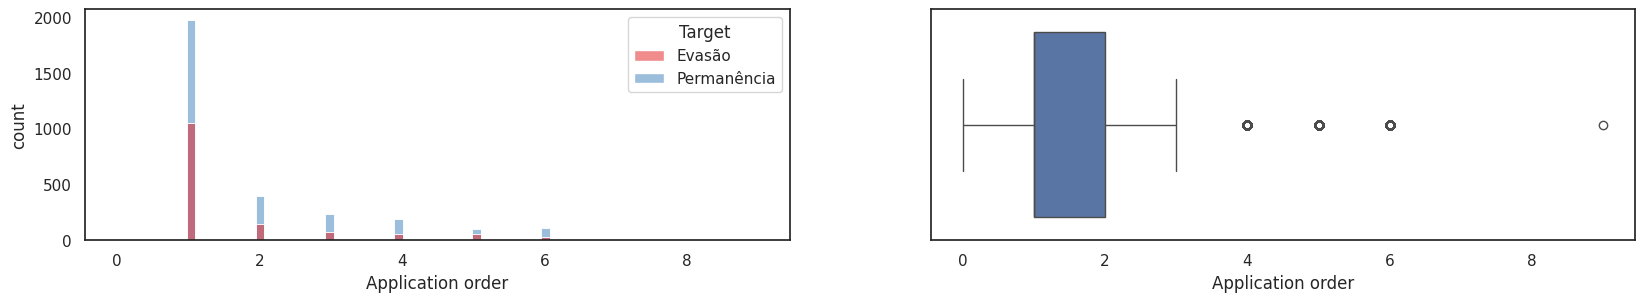

Curricular units 1st sem (credited)

Média : 0.71
Mediana : 0.0
Variância : 5.57
Desvio padrão : 2.36
Min : 0
Max : 20
Intervalo:  20
Amostras únicas : 21
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 4.17
Curtose : 19.21


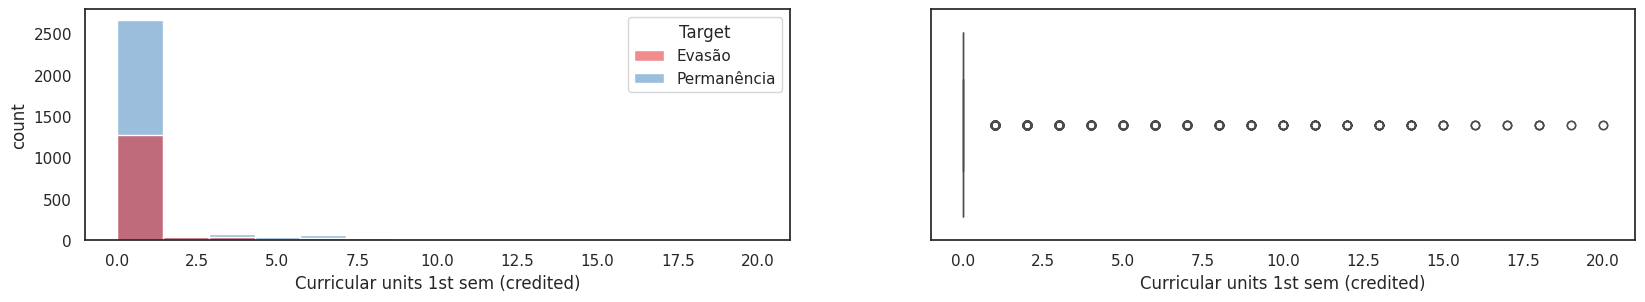

Curricular units 1st sem (enrolled)

Média : 6.27
Mediana : 6.0
Variância : 6.15
Desvio padrão : 2.48
Min : 0
Max : 26
Intervalo:  26
Amostras únicas : 23
Amostras faltando : 0
Q1 : 5.0
Q3 : 7.0
IQR : 2.0
Limite inferior : 2.0
Limite superior : 10.0
Obliquidade : 1.62
Curtose : 8.94


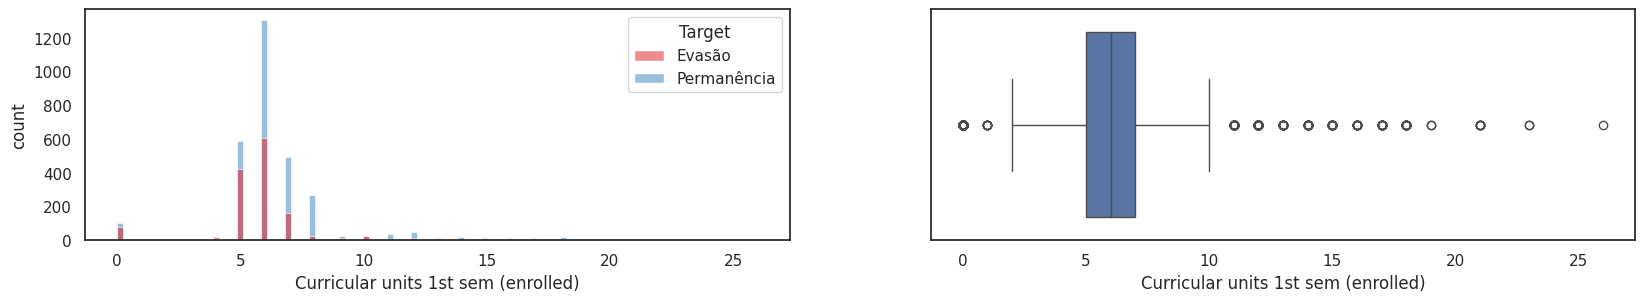

Curricular units 1st sem (evaluations)

Média : 8.3
Mediana : 8.0
Variância : 17.46
Desvio padrão : 4.18
Min : 0
Max : 45
Intervalo:  45
Amostras únicas : 35
Amostras faltando : 0
Q1 : 6.0
Q3 : 10.0
IQR : 4.0
Limite inferior : 0.0
Limite superior : 16.0
Obliquidade : 0.98
Curtose : 5.46


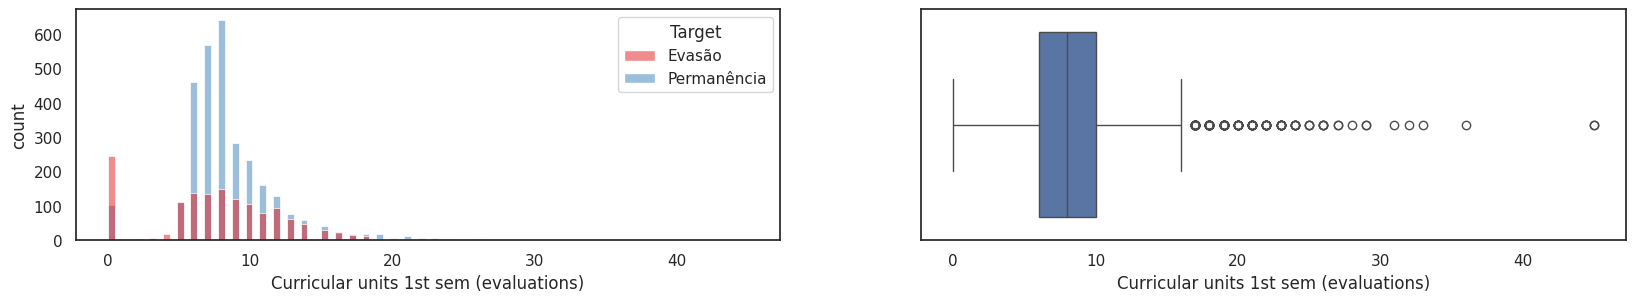

Curricular units 1st sem (approved)

Média : 4.71
Mediana : 5.0
Variância : 9.57
Desvio padrão : 3.09
Min : 0
Max : 26
Intervalo:  26
Amostras únicas : 23
Amostras faltando : 0
Q1 : 3.0
Q3 : 6.0
IQR : 3.0
Limite inferior : -1.5
Limite superior : 10.5
Obliquidade : 0.77
Curtose : 3.1


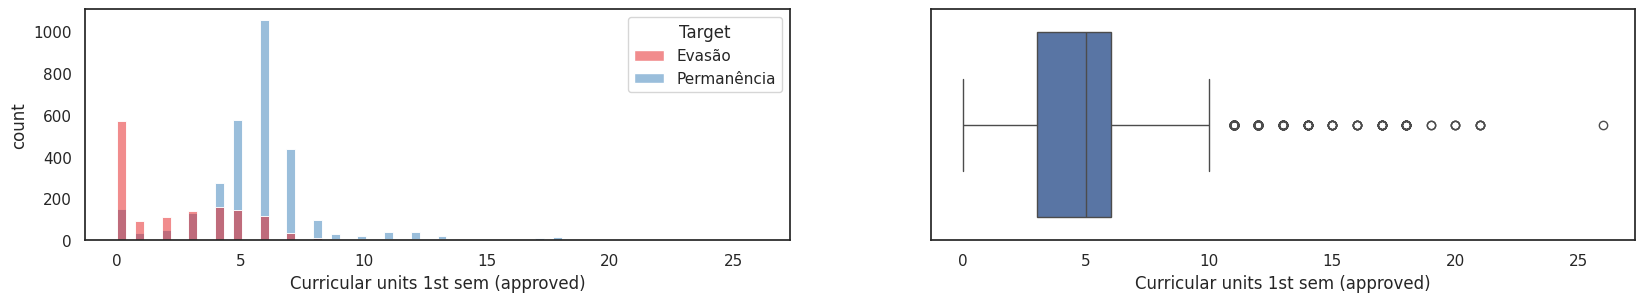

Curricular units 1st sem (grade)

Média : 10.64
Mediana : 12.29
Variância : 23.46
Desvio padrão : 4.84
Min : 0.0
Max : 18.88
Intervalo:  18.88
Amostras únicas : 805
Amostras faltando : 0
Q1 : 11.0
Q3 : 13.4
IQR : 2.4
Limite inferior : 7.4
Limite superior : 17.0
Obliquidade : -1.57
Curtose : 0.91


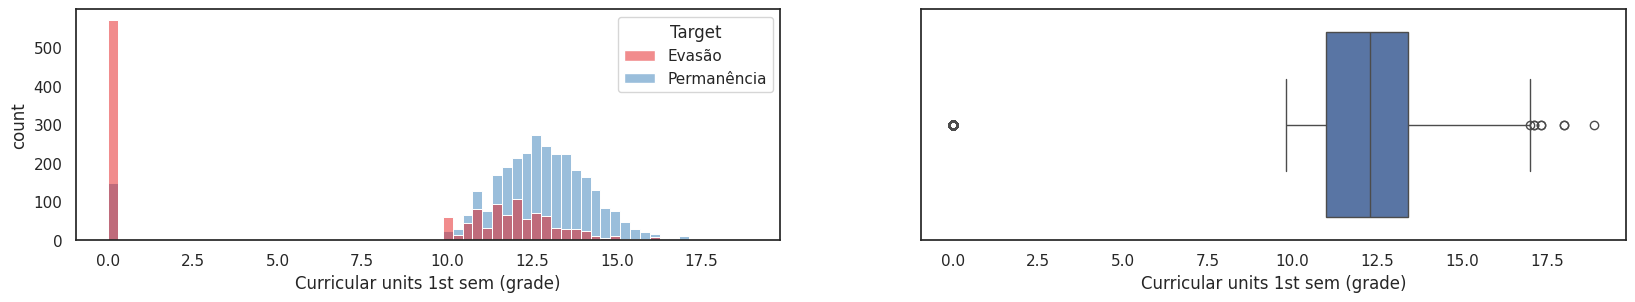

Curricular units 1st sem (without evaluations)

Média : 0.14
Mediana : 0.0
Variância : 0.48
Desvio padrão : 0.69
Min : 0
Max : 12
Intervalo:  12
Amostras únicas : 11
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 8.21
Curtose : 89.86


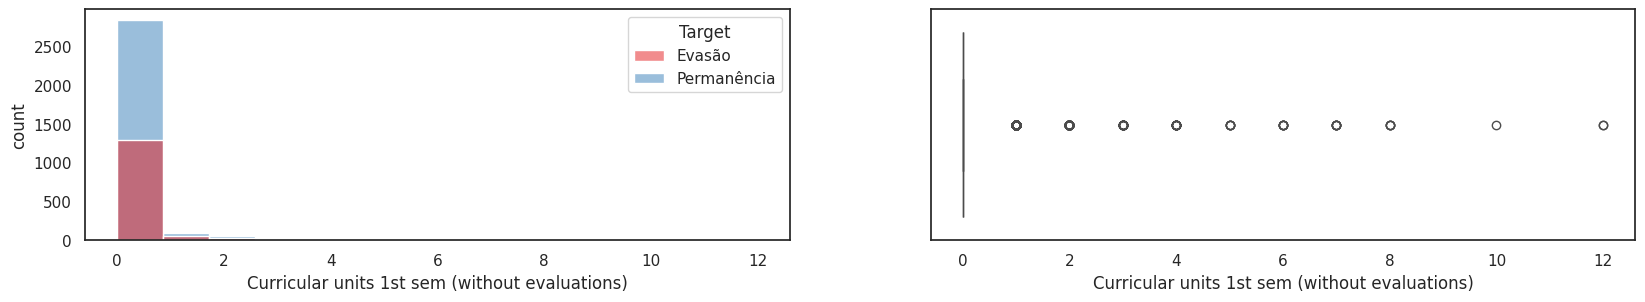

Curricular units 2nd sem (credited)

Média : 0.54
Mediana : 0.0
Variância : 3.68
Desvio padrão : 1.92
Min : 0
Max : 19
Intervalo:  19
Amostras únicas : 19
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 4.63
Curtose : 24.43


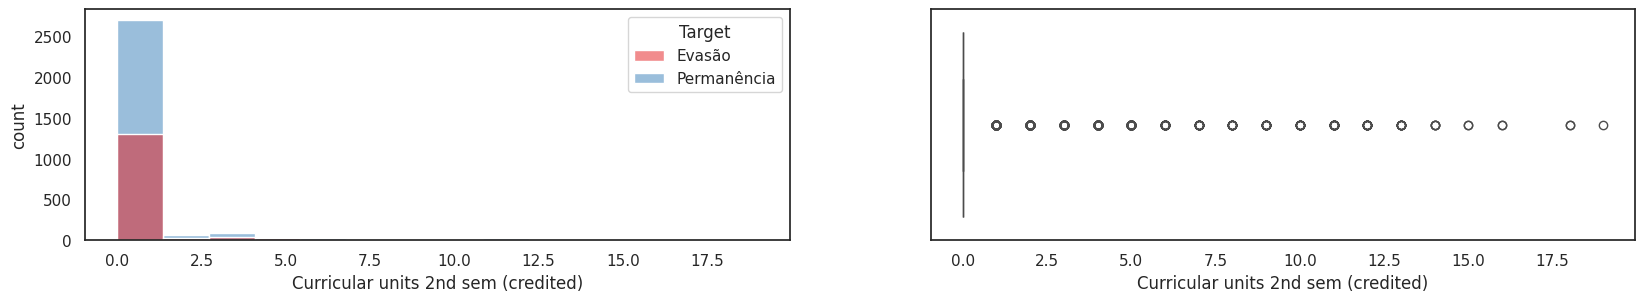

Curricular units 2nd sem (enrolled)

Média : 6.23
Mediana : 6.0
Variância : 4.82
Desvio padrão : 2.2
Min : 0
Max : 23
Intervalo:  23
Amostras únicas : 22
Amostras faltando : 0
Q1 : 5.0
Q3 : 7.0
IQR : 2.0
Limite inferior : 2.0
Limite superior : 10.0
Obliquidade : 0.79
Curtose : 7.13


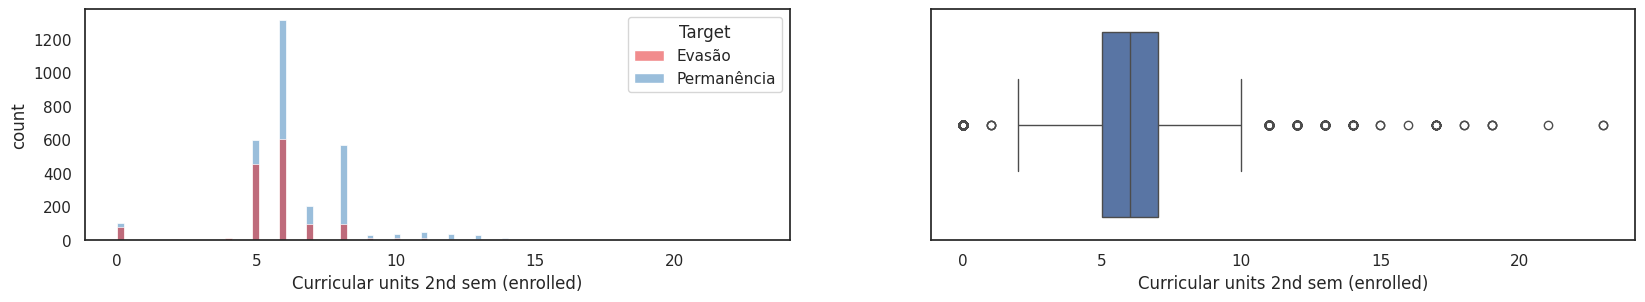

Curricular units 2nd sem (evaluations)

Média : 8.06
Mediana : 8.0
Variância : 15.59
Desvio padrão : 3.95
Min : 0
Max : 33
Intervalo:  33
Amostras únicas : 30
Amostras faltando : 0
Q1 : 6.0
Q3 : 10.0
IQR : 4.0
Limite inferior : 0.0
Limite superior : 16.0
Obliquidade : 0.34
Curtose : 2.07


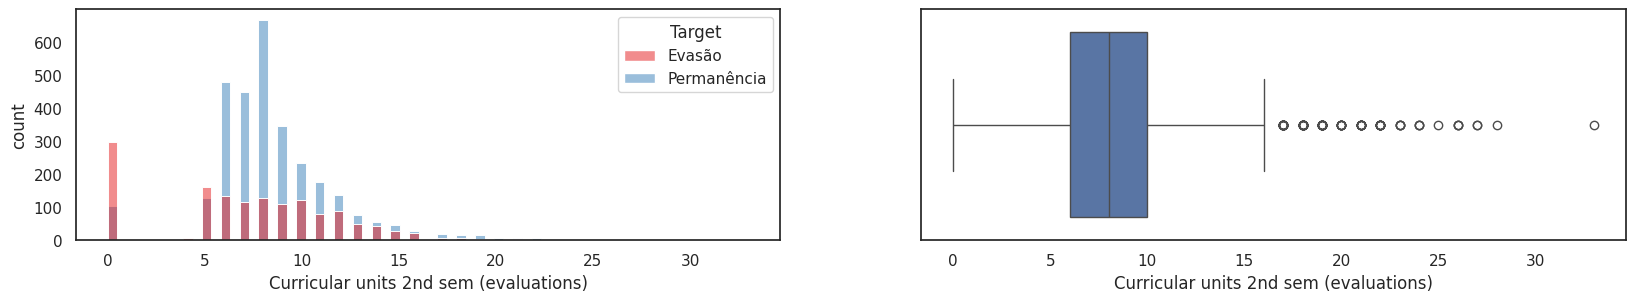

Curricular units 2nd sem (approved)

Média : 4.44
Mediana : 5.0
Variância : 9.09
Desvio padrão : 3.01
Min : 0
Max : 20
Intervalo:  20
Amostras únicas : 20
Amostras faltando : 0
Q1 : 2.0
Q3 : 6.0
IQR : 4.0
Limite inferior : -4.0
Limite superior : 12.0
Obliquidade : 0.31
Curtose : 0.85


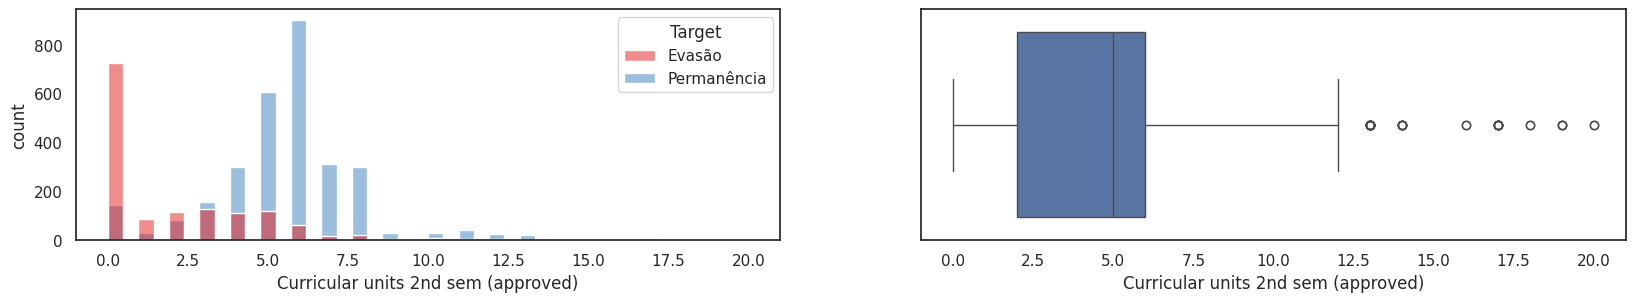

Curricular units 2nd sem (grade)

Média : 10.23
Mediana : 12.2
Variância : 27.15
Desvio padrão : 5.21
Min : 0.0
Max : 18.57
Intervalo:  18.57
Amostras únicas : 786
Amostras faltando : 0
Q1 : 10.75
Q3 : 13.33
IQR : 2.58
Limite inferior : 6.87
Limite superior : 17.21
Obliquidade : -1.31
Curtose : 0.07


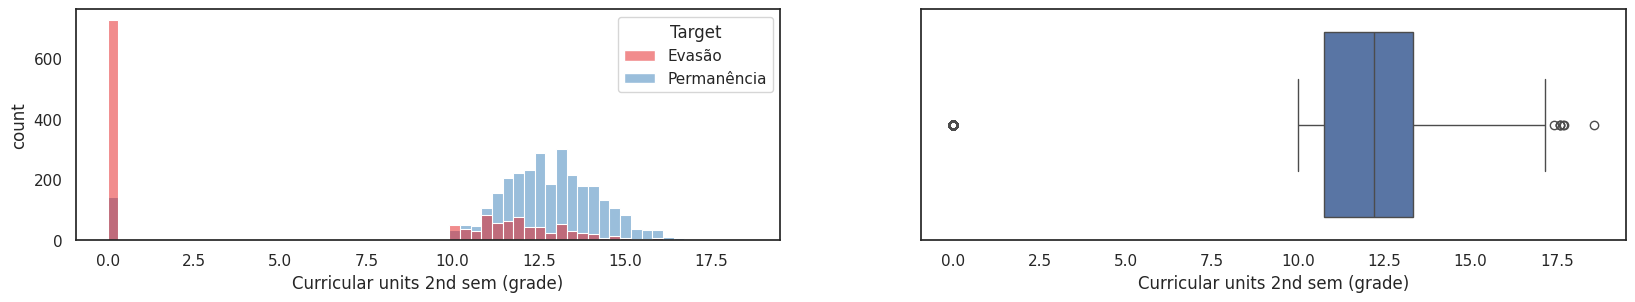

Curricular units 2nd sem (without evaluations)

Média : 0.15
Mediana : 0.0
Variância : 0.57
Desvio padrão : 0.75
Min : 0
Max : 12
Intervalo:  12
Amostras únicas : 10
Amostras faltando : 0
Q1 : 0.0
Q3 : 0.0
IQR : 0.0
Limite inferior : 0.0
Limite superior : 0.0
Obliquidade : 7.27
Curtose : 66.81


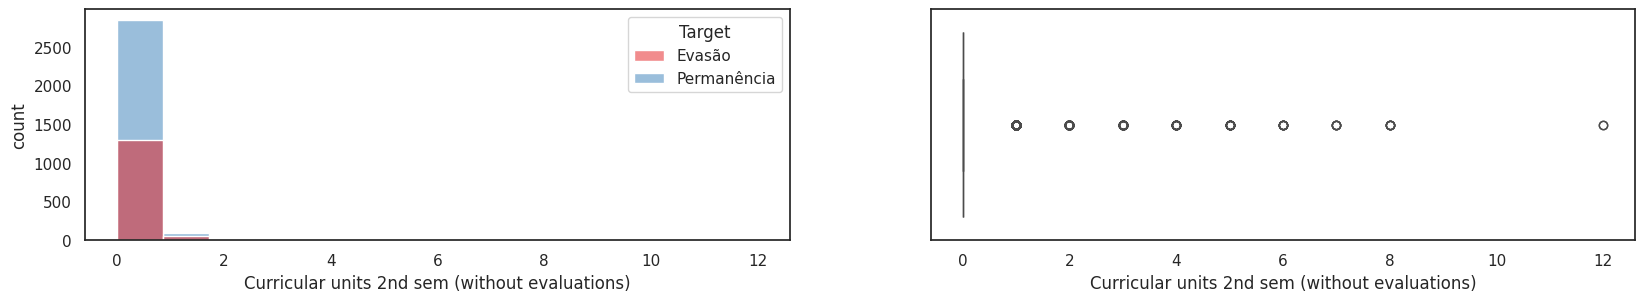

Unemployment rate

Média : 11.57
Mediana : 11.1
Variância : 7.1
Desvio padrão : 2.66
Min : 7.6
Max : 16.2
Intervalo:  8.6
Amostras únicas : 10
Amostras faltando : 0
Q1 : 9.4
Q3 : 13.9
IQR : 4.5
Limite inferior : 2.65
Limite superior : 20.65
Obliquidade : 0.21
Curtose : -1.0


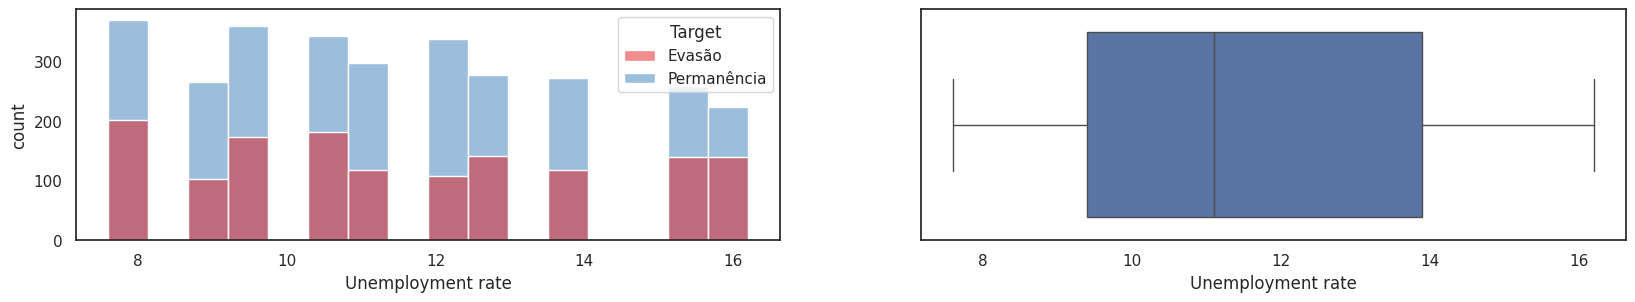

Inflation rate

Média : 1.23
Mediana : 1.4
Variância : 1.91
Desvio padrão : 1.38
Min : -0.8
Max : 3.7
Intervalo:  4.5
Amostras únicas : 9
Amostras faltando : 0
Q1 : 0.3
Q3 : 2.6
IQR : 2.3
Limite inferior : -3.15
Limite superior : 6.05
Obliquidade : 0.25
Curtose : -1.04


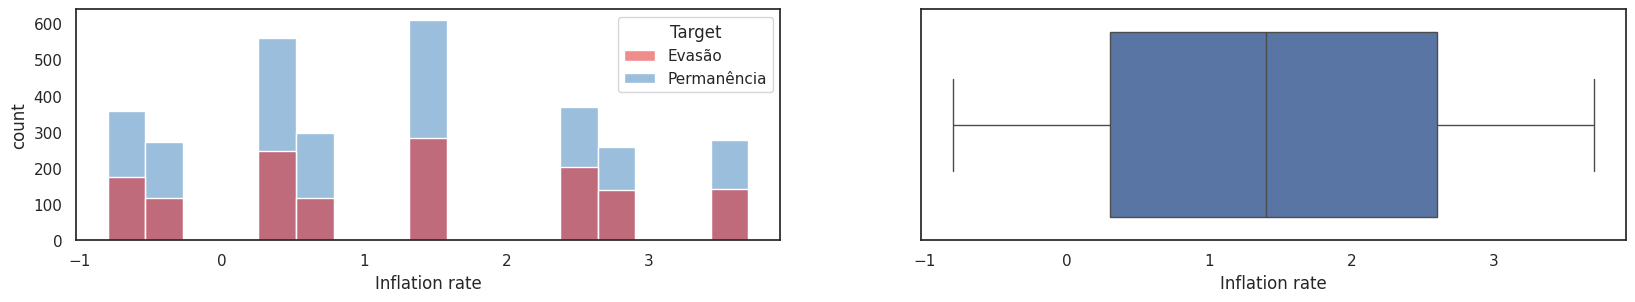

GDP

Média : 0.0
Mediana : 0.32
Variância : 5.15
Desvio padrão : 2.27
Min : -4.06
Max : 3.51
Intervalo:  7.57
Amostras únicas : 10
Amostras faltando : 0
Q1 : -1.7
Q3 : 1.79
IQR : 3.49
Limite inferior : -6.94
Limite superior : 7.02
Obliquidade : -0.39
Curtose : -1.0


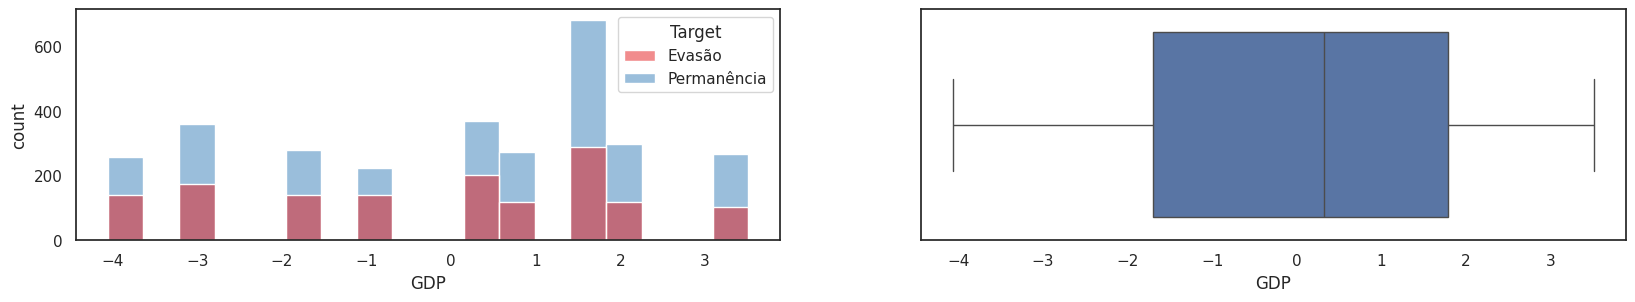

Age at enrollment

Média : 23.27
Mediana : 20.0
Variância : 57.57
Desvio padrão : 7.59
Min : 17
Max : 70
Intervalo:  53
Amostras únicas : 46
Amostras faltando : 0
Q1 : 19.0
Q3 : 25.0
IQR : 6.0
Limite inferior : 10.0
Limite superior : 34.0
Obliquidade : 2.05
Curtose : 4.13


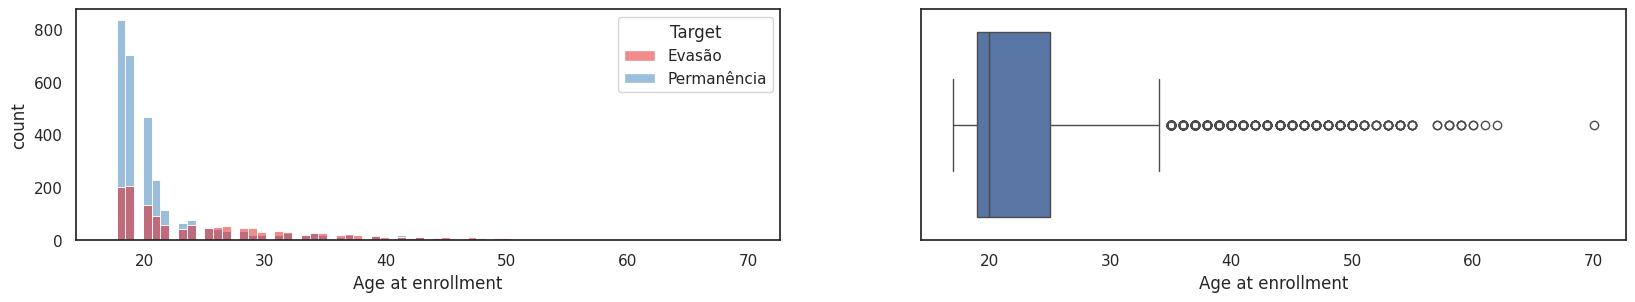

In [817]:
for col in numerical_data:
    
    # Atributo
    print(col, end="\n\n")

    # Estatísticas descritivas
    print('Média :', round(data[col].mean(), 2))
    print('Mediana :', round(data[col].median(), 2))
    print('Variância :', round(data[col].var(), 2))
    print('Desvio padrão :', round(data[col].std(), 2))
    print('Min :', round(data[col].min(), 2))
    print('Max :', round(data[col].max(), 2))
    print('Intervalo: ', round(data[col].max() - data[col].min(), 2))
    print('Amostras únicas :', data[col].nunique())
    print('Amostras faltando :', data[col].isnull().sum())
    print('Q1 :', round(data[col].quantile(0.25), 2))
    print('Q3 :', round(data[col].quantile(0.75), 2))
    print('IQR :', round(data[col].quantile(0.75) - data[col].quantile(0.25), 2))
    print('Limite inferior :', round(data[col].quantile(0.25) - 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Limite superior :', round(data[col].quantile(0.75) + 1.5 * (data[col].quantile(0.75) - data[col].quantile(0.25)), 2))
    print('Obliquidade :', round(data[col].skew(), 2))
    print('Curtose :', round(data[col].kurt(), 2))

    # Gráficos - referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/
    plt.figure(figsize = (20, 3))
    plt.subplot(1, 2, 1)
    # data[col].hist(grid=False)
    sns.histplot(data=data, x=col, hue='Target', kde=False, palette='Set1')
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=data[col])
    plt.show()

### Atributos categóricos
Gráficos:
- Histograma: distribuição de frequência (contagem das classes)

Estatística descritiva:
- Moda
- Invervalo
- Variância
- Desvio padrão

#### a. Distribuição de frequência

Application mode

Moda : 0    1st phase—general contingent
Name: Application mode, dtype: object
Amostras únicas : 18
Amostras faltando : 0


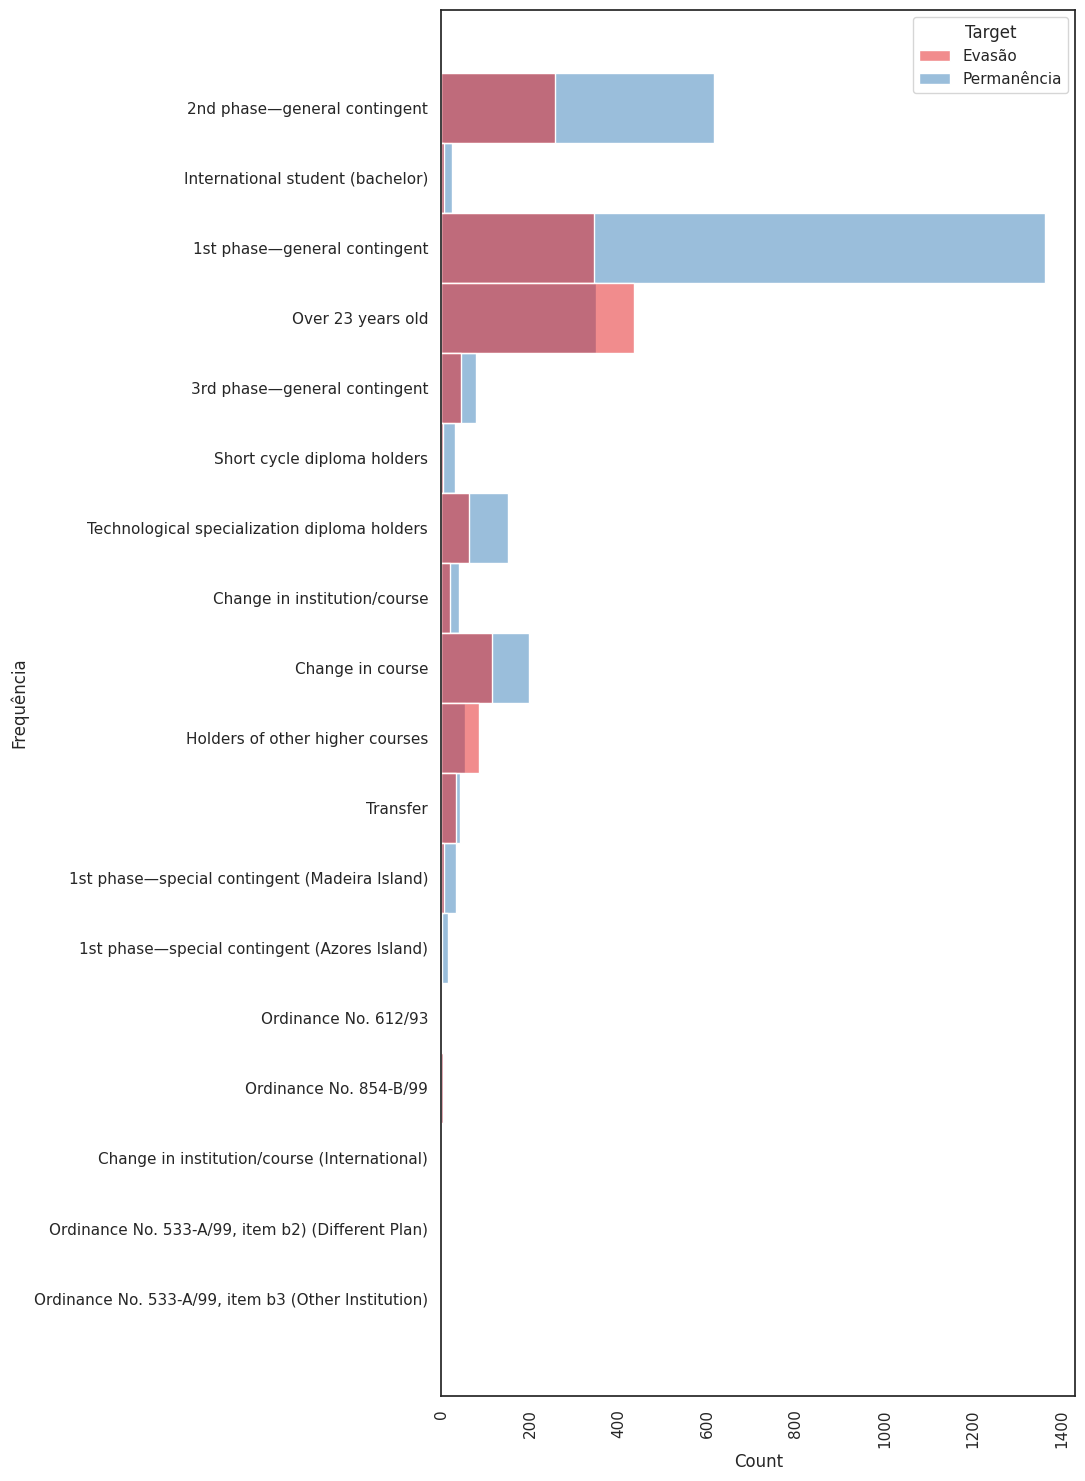

Course

Moda : 0    Nursing
Name: Course, dtype: object
Amostras únicas : 17
Amostras faltando : 0


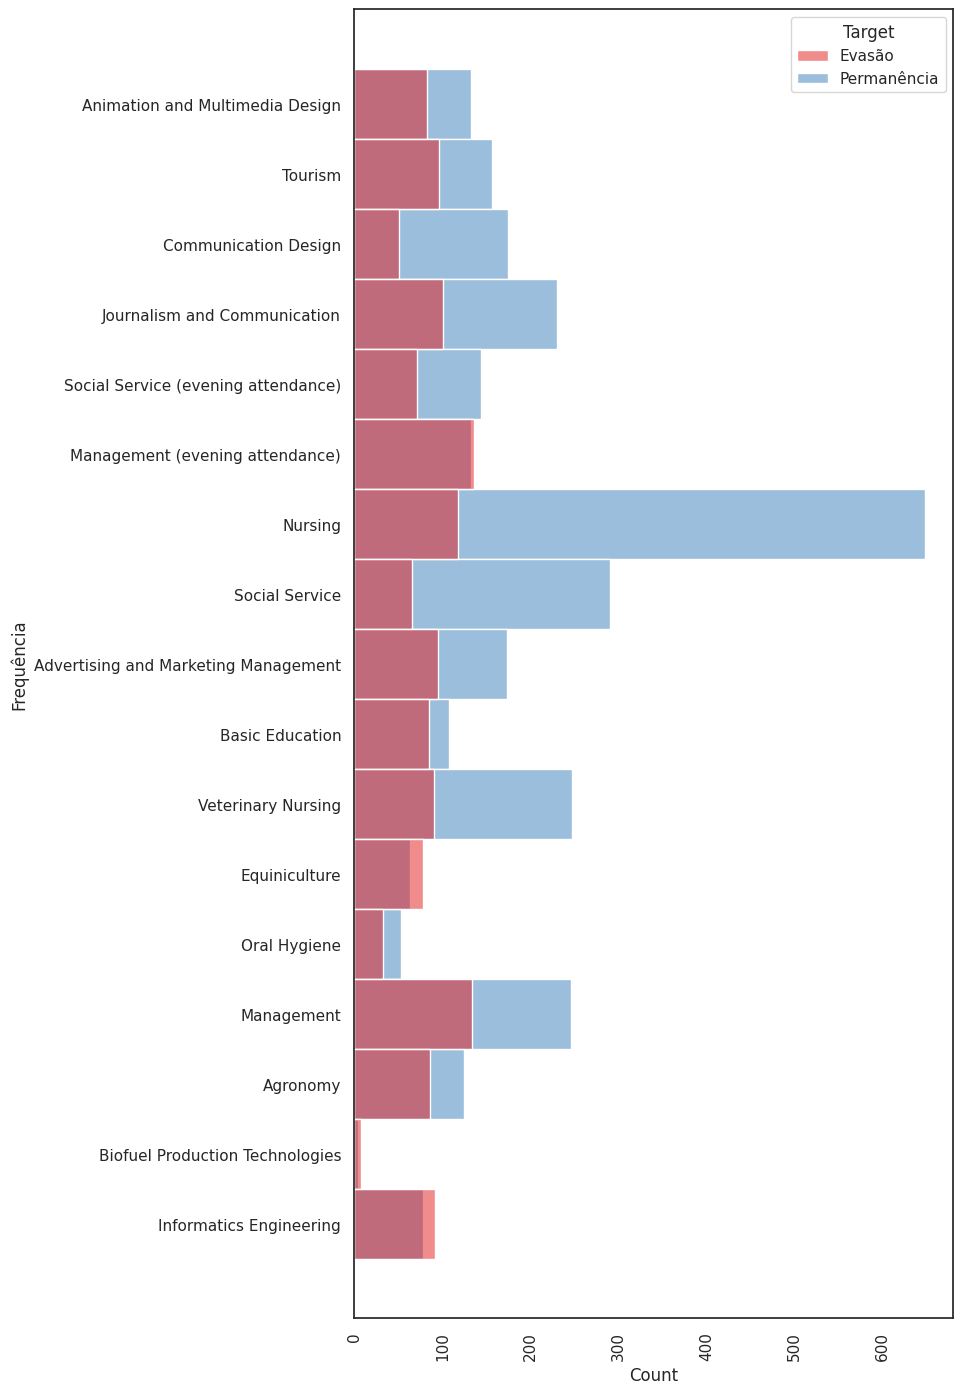

Previous qualification

Moda : 0    Secondary education
Name: Previous qualification, dtype: object
Amostras únicas : 17
Amostras faltando : 0


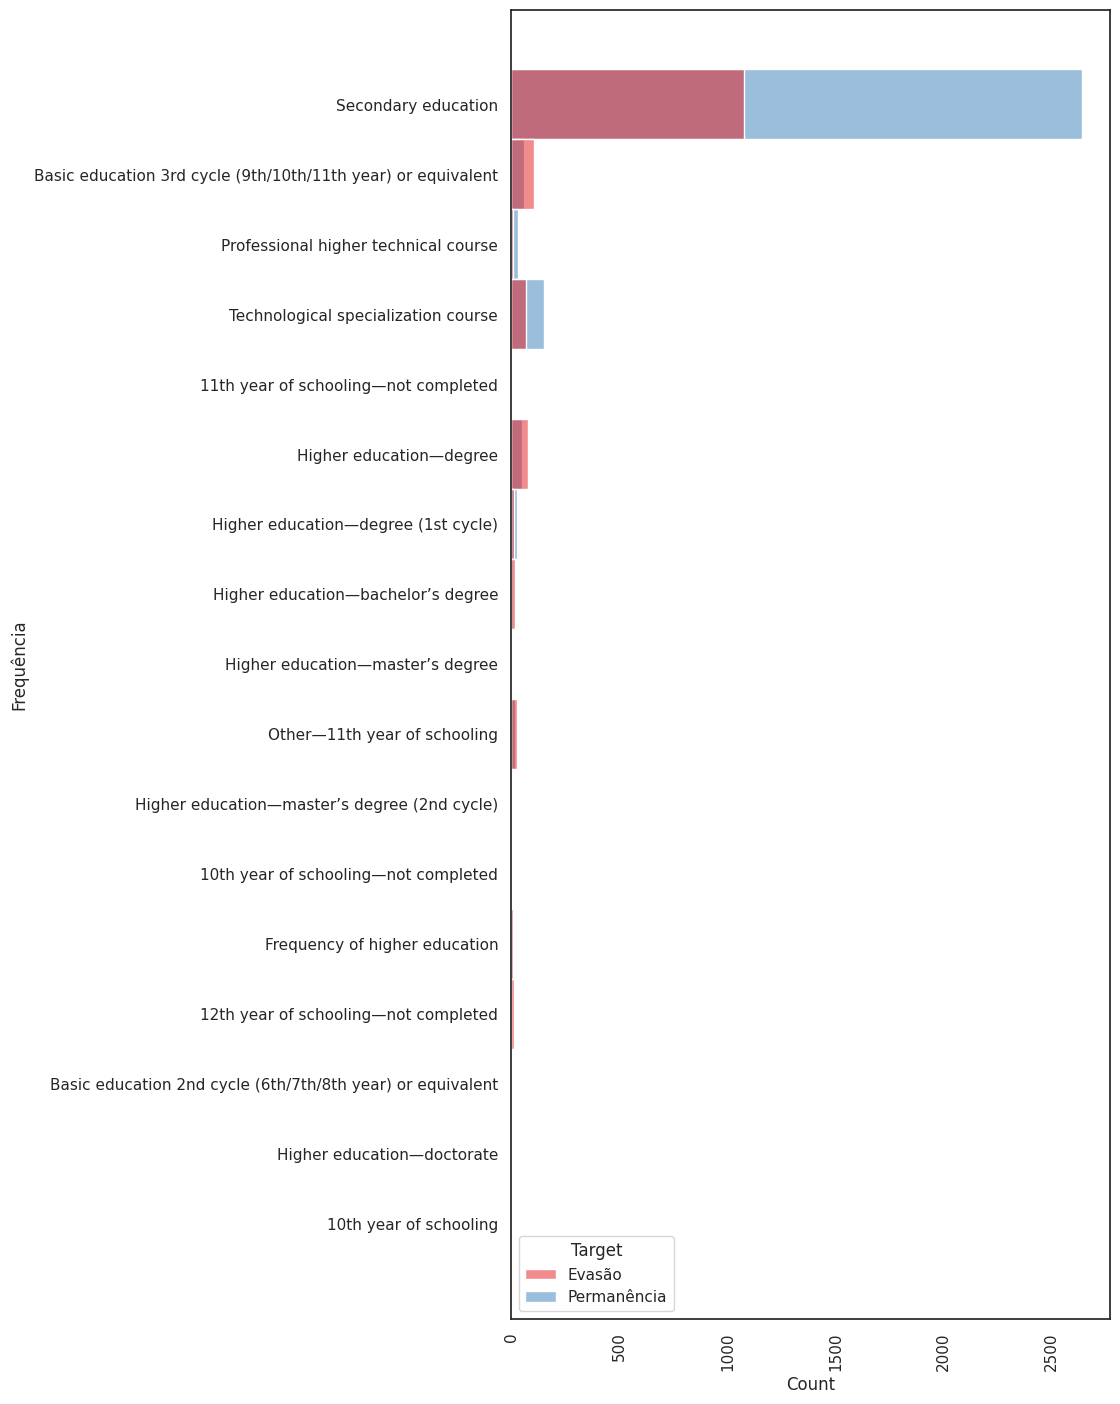

Nacionality

Moda : 0    Portuguese
Name: Nacionality, dtype: object
Amostras únicas : 21
Amostras faltando : 0


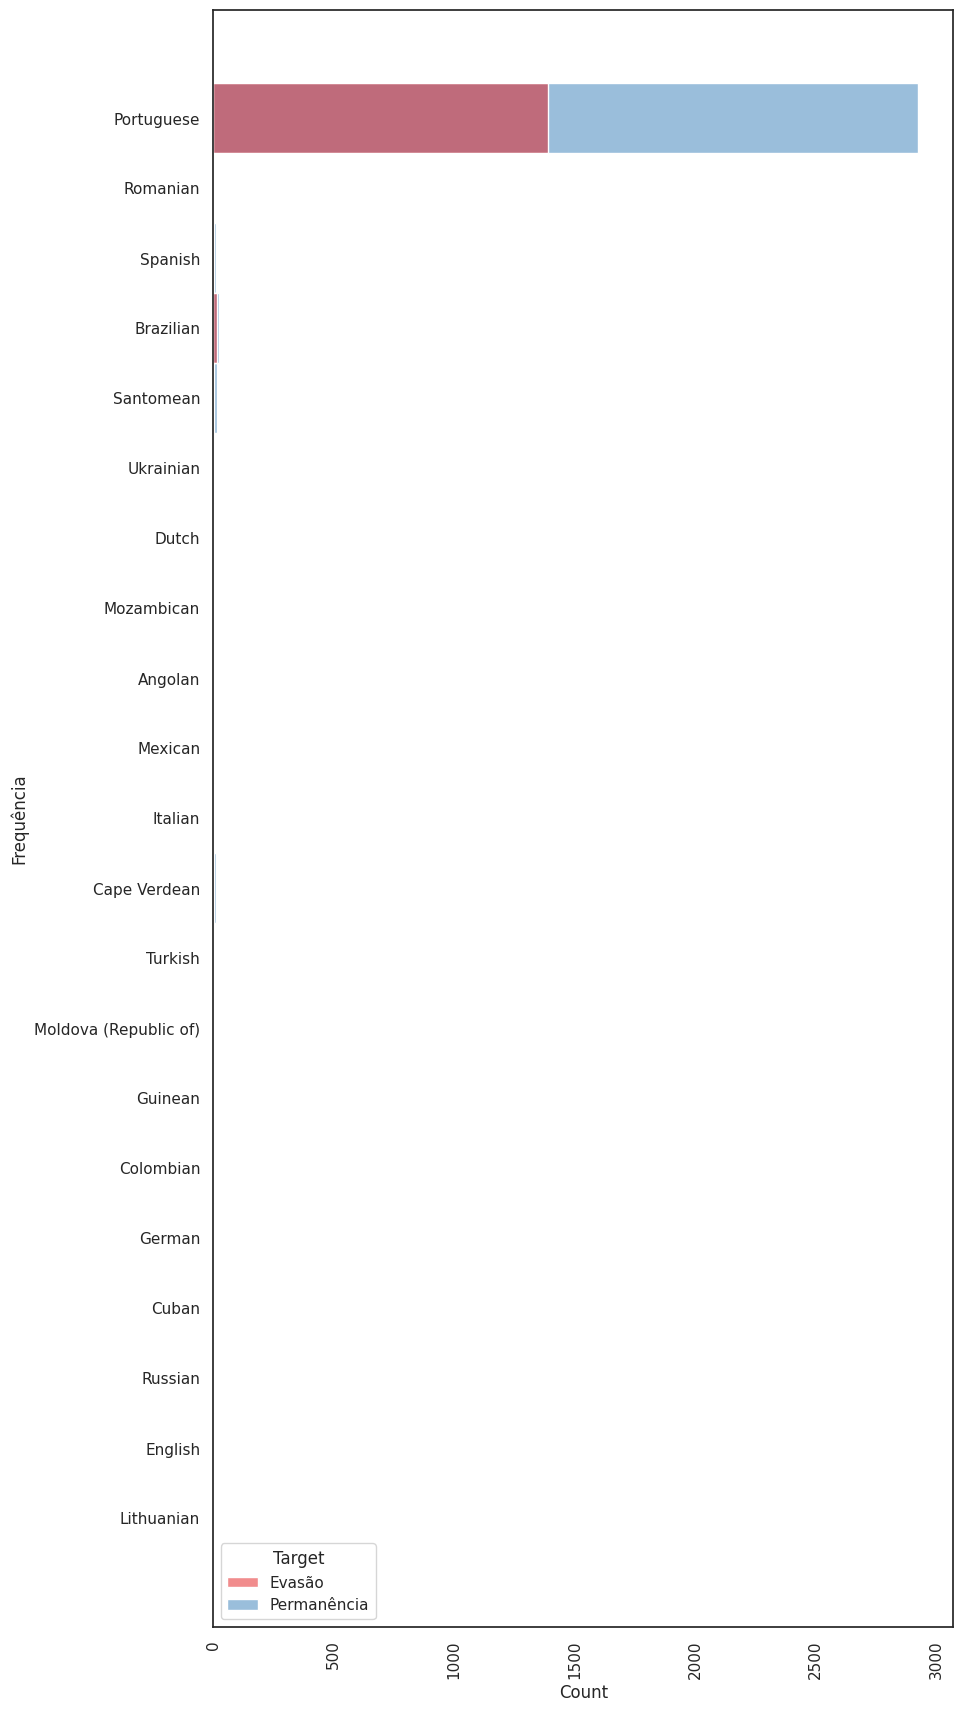

Mother's qualification

Moda : 0    Secondary Education—12th Year of Schooling or ...
Name: Mother's qualification, dtype: object
Amostras únicas : 29
Amostras faltando : 0


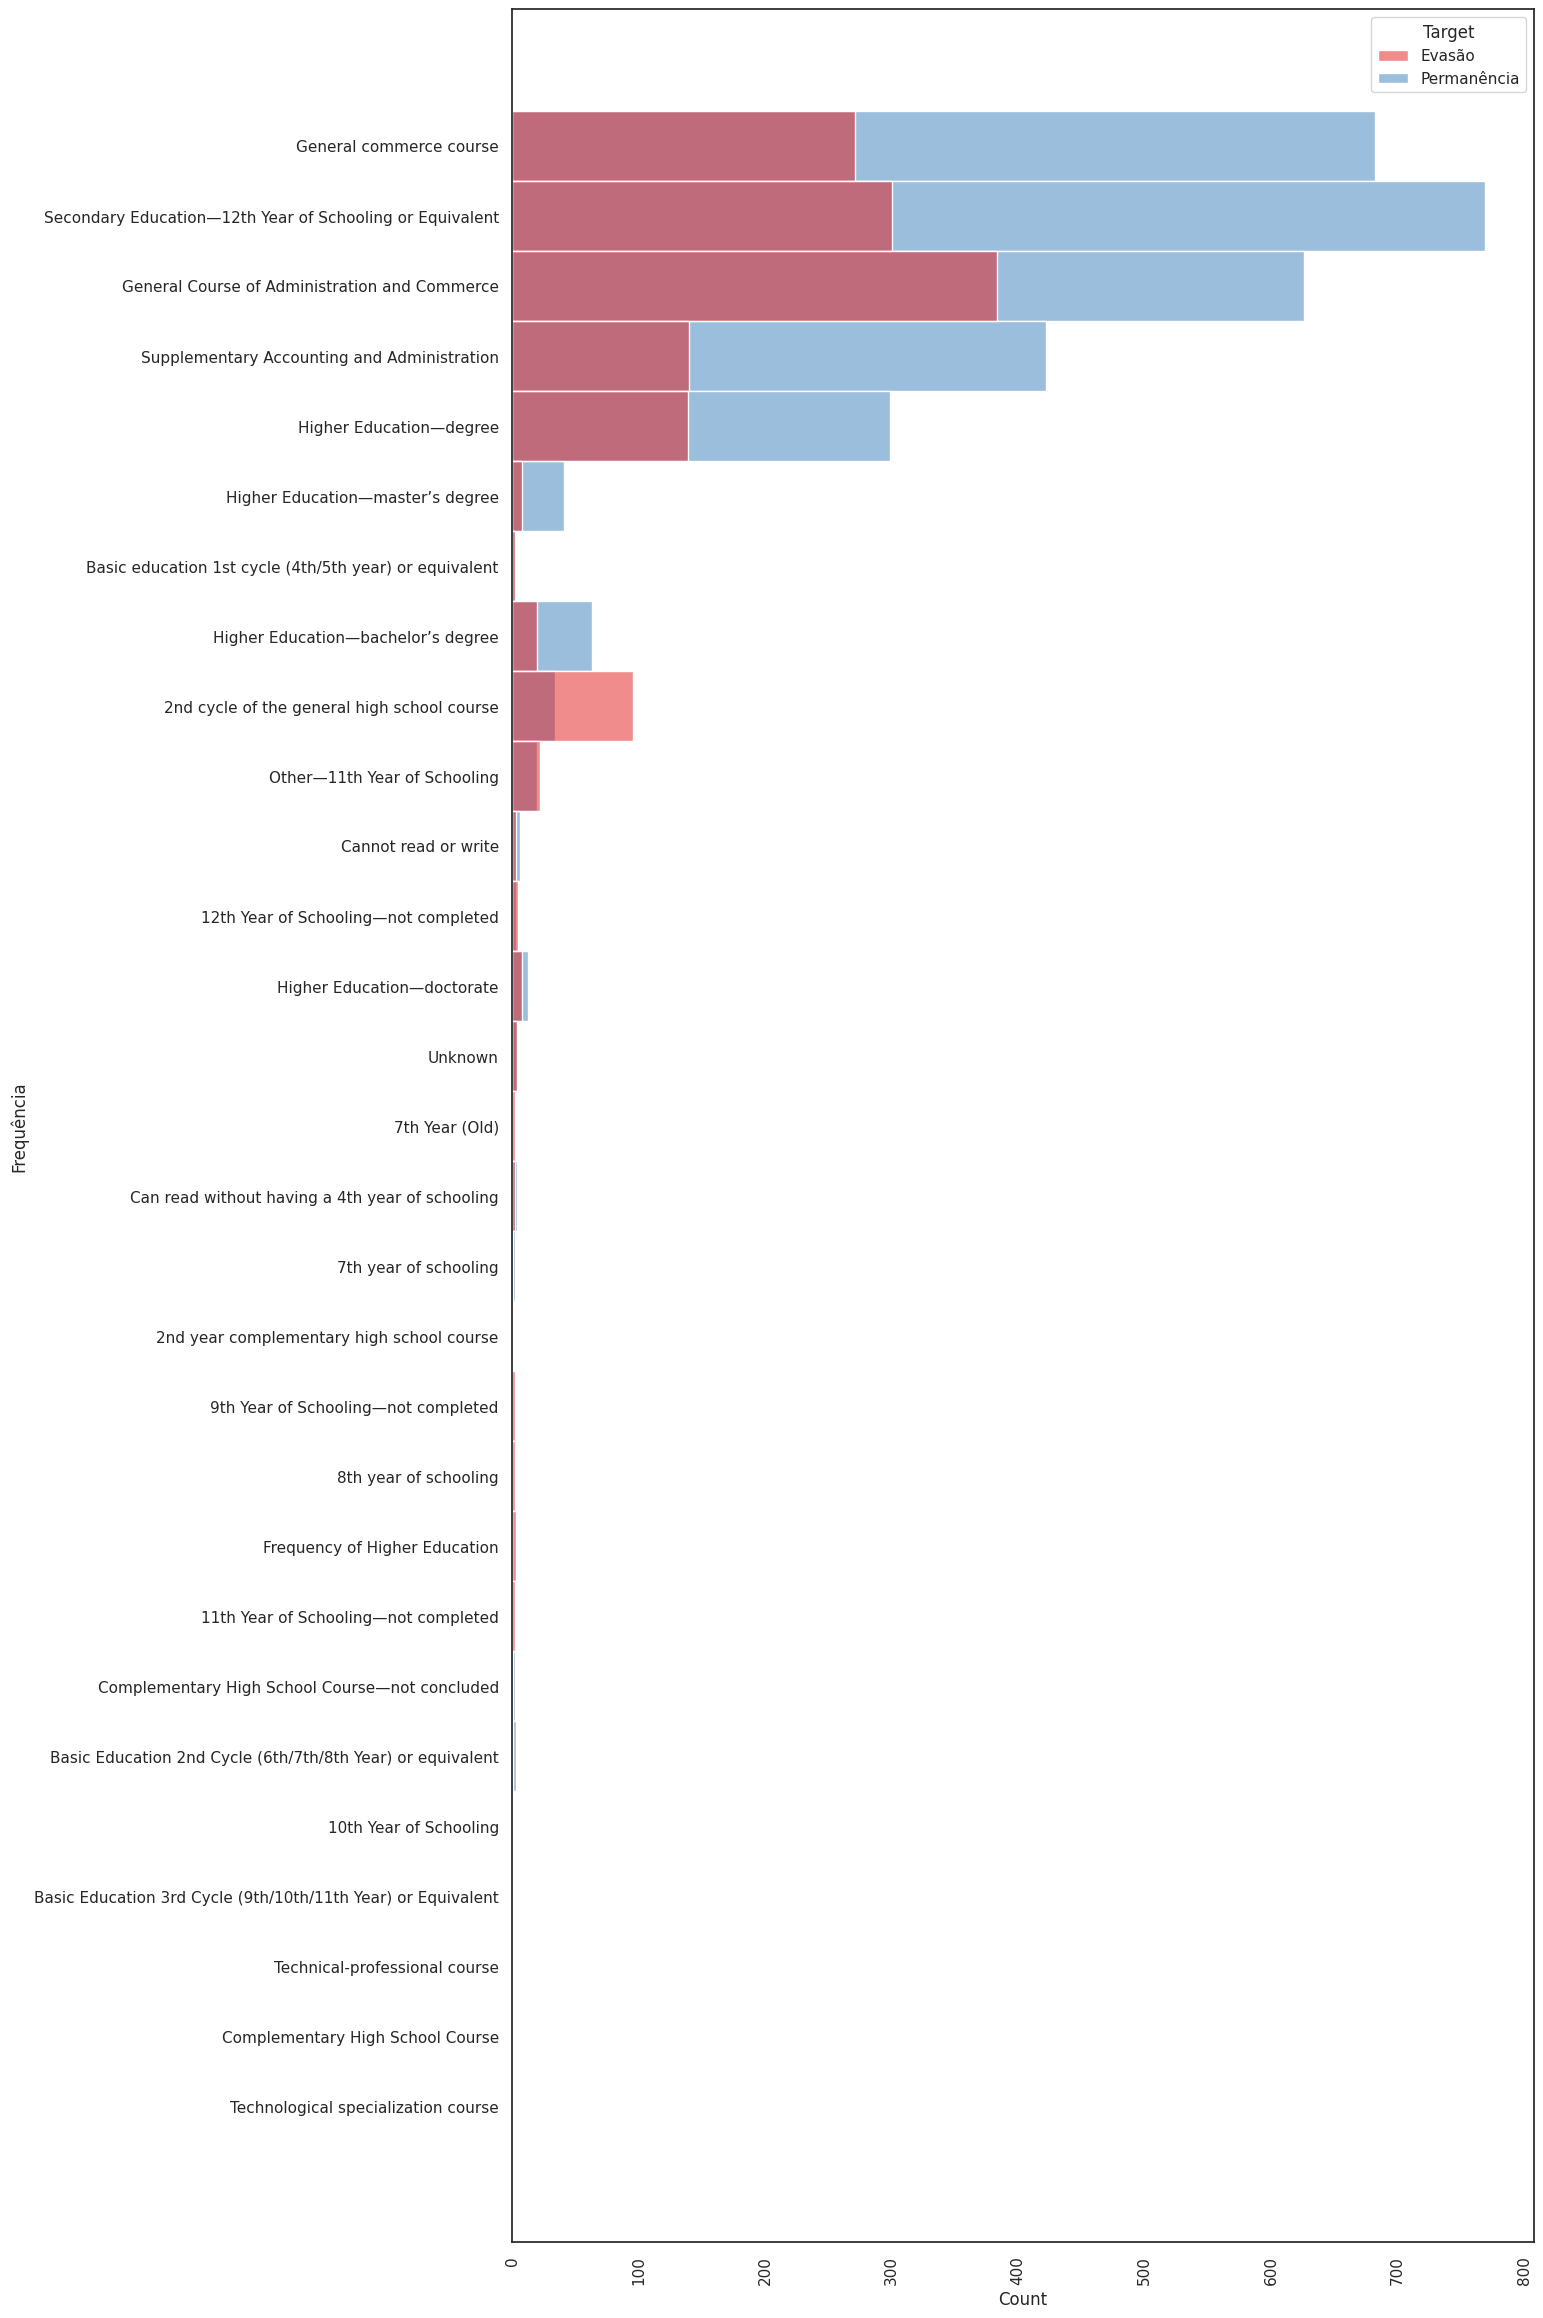

Father's qualification

Moda : 0    Basic education 1st cycle (4th/5th year) or eq...
Name: Father's qualification, dtype: object
Amostras únicas : 34
Amostras faltando : 0


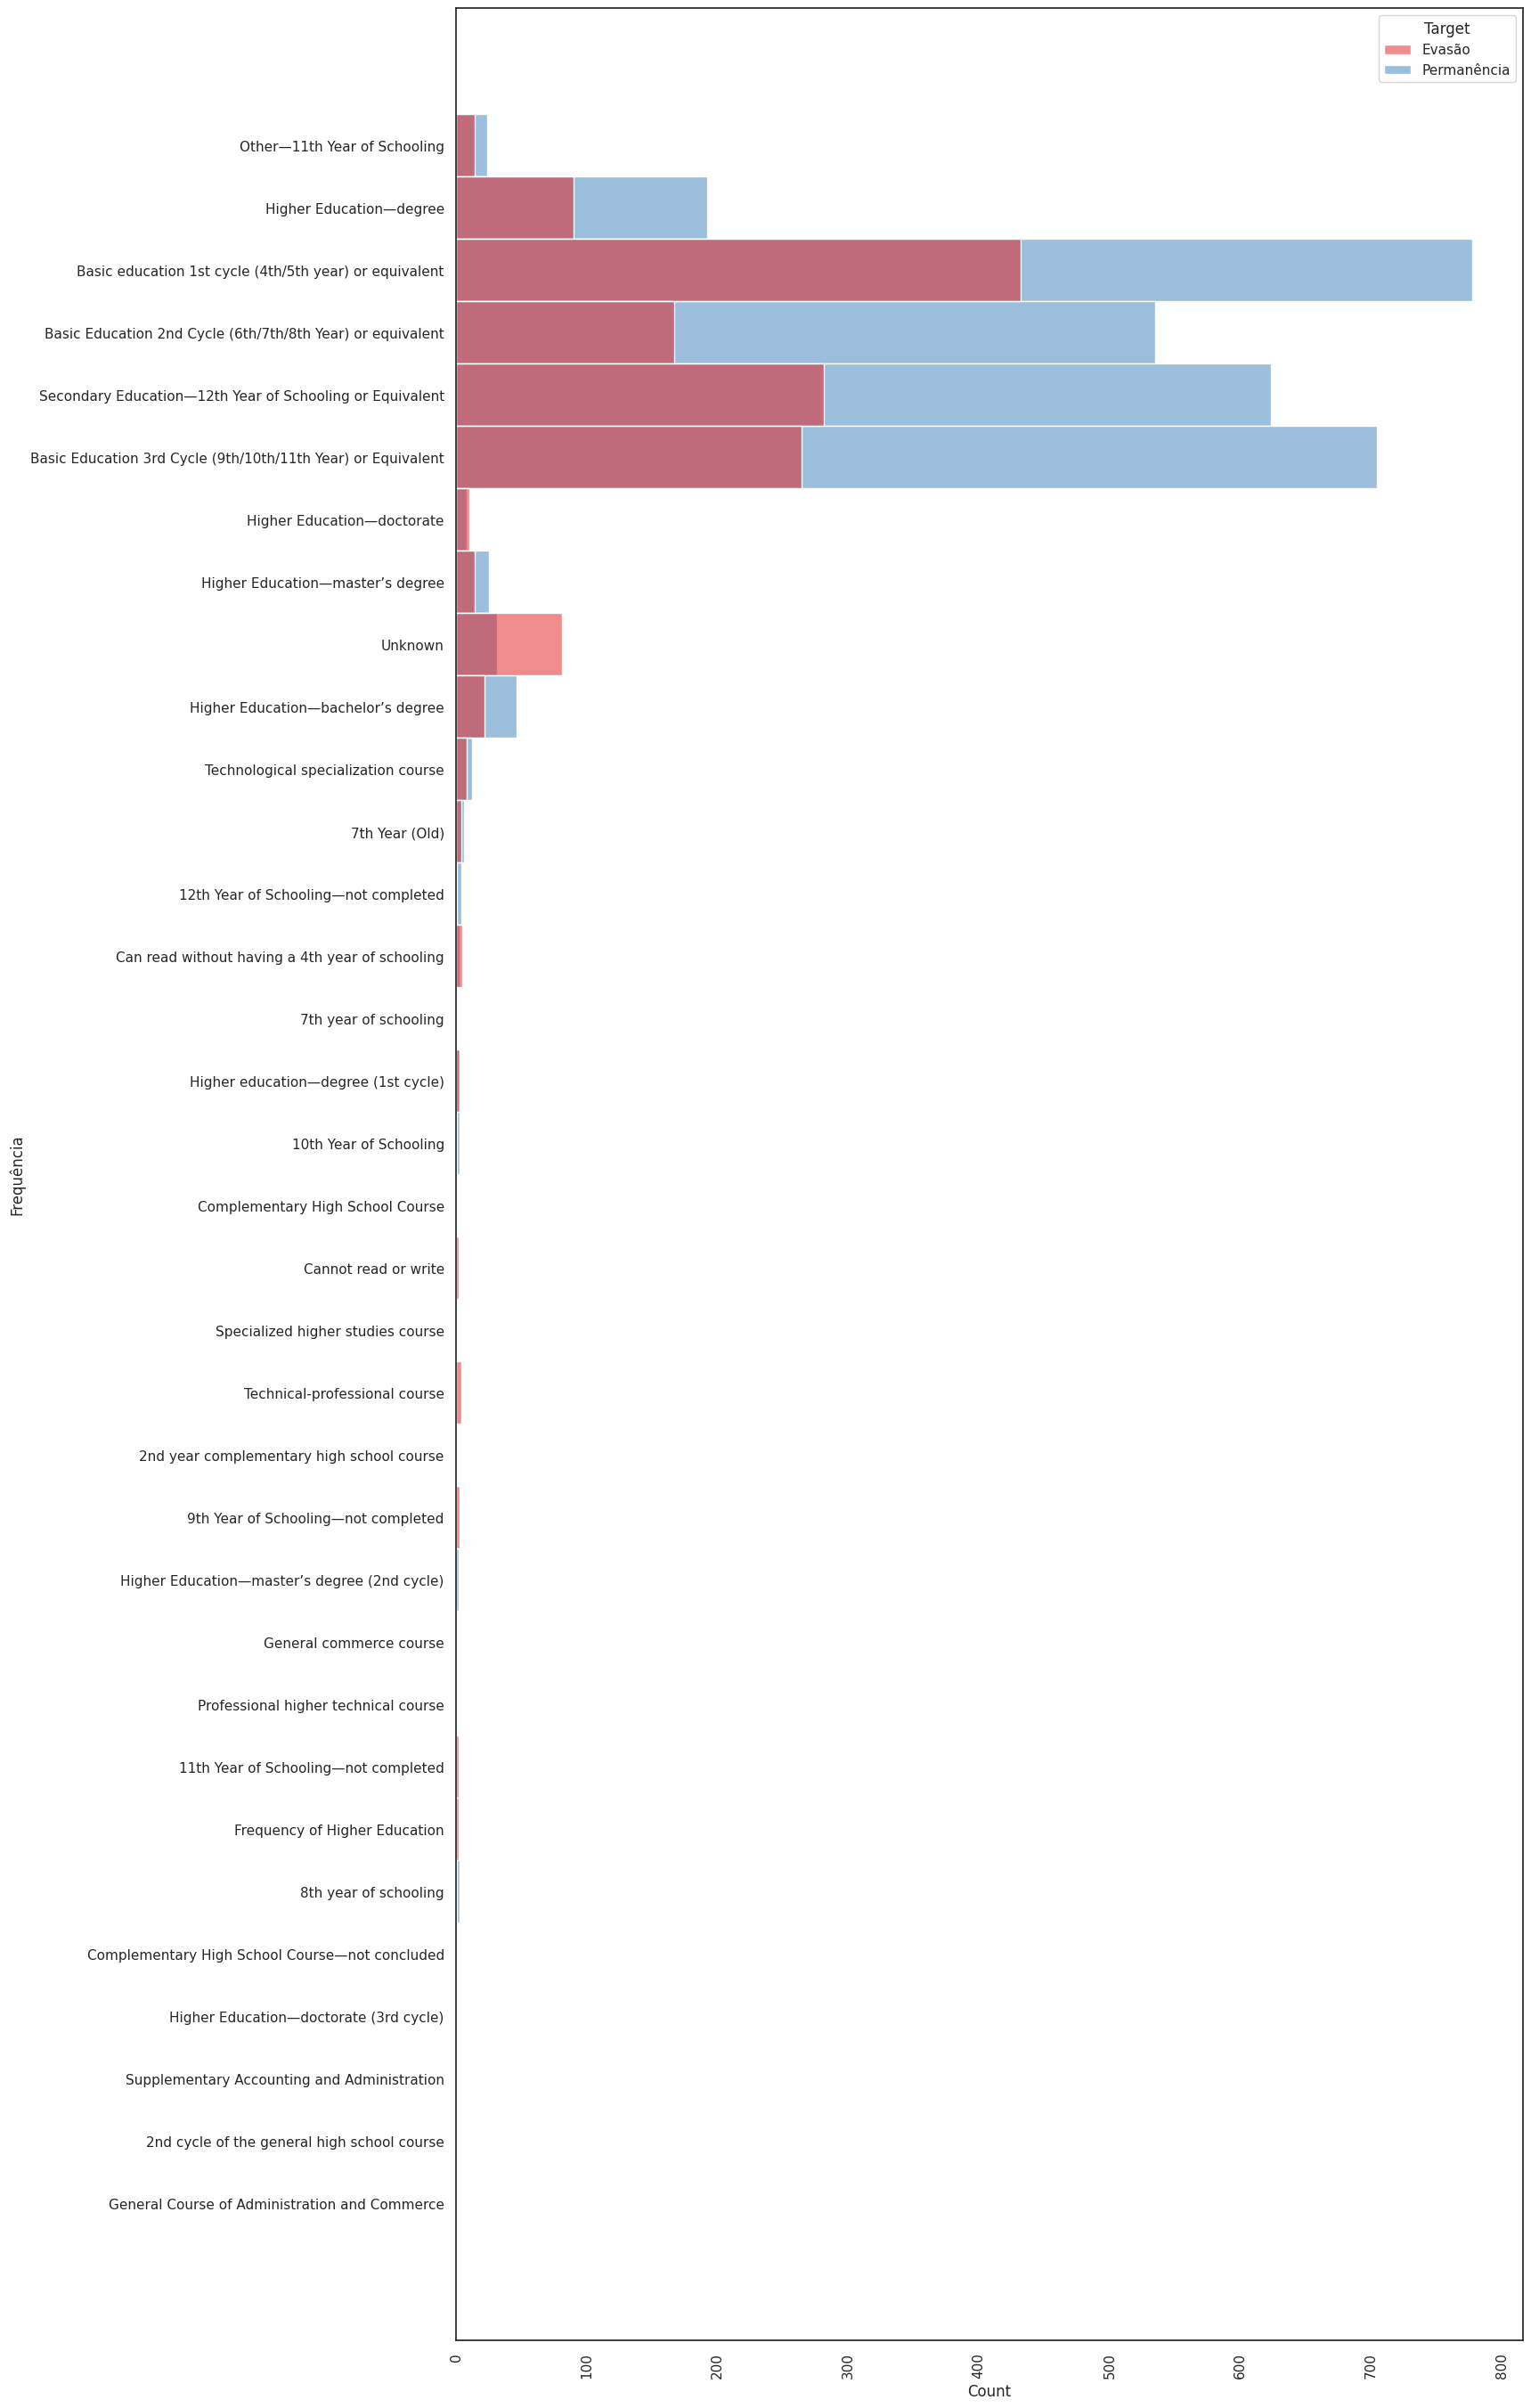

Mother's occupation

Moda : 0    Unskilled Workers
Name: Mother's occupation, dtype: object
Amostras únicas : 32
Amostras faltando : 0


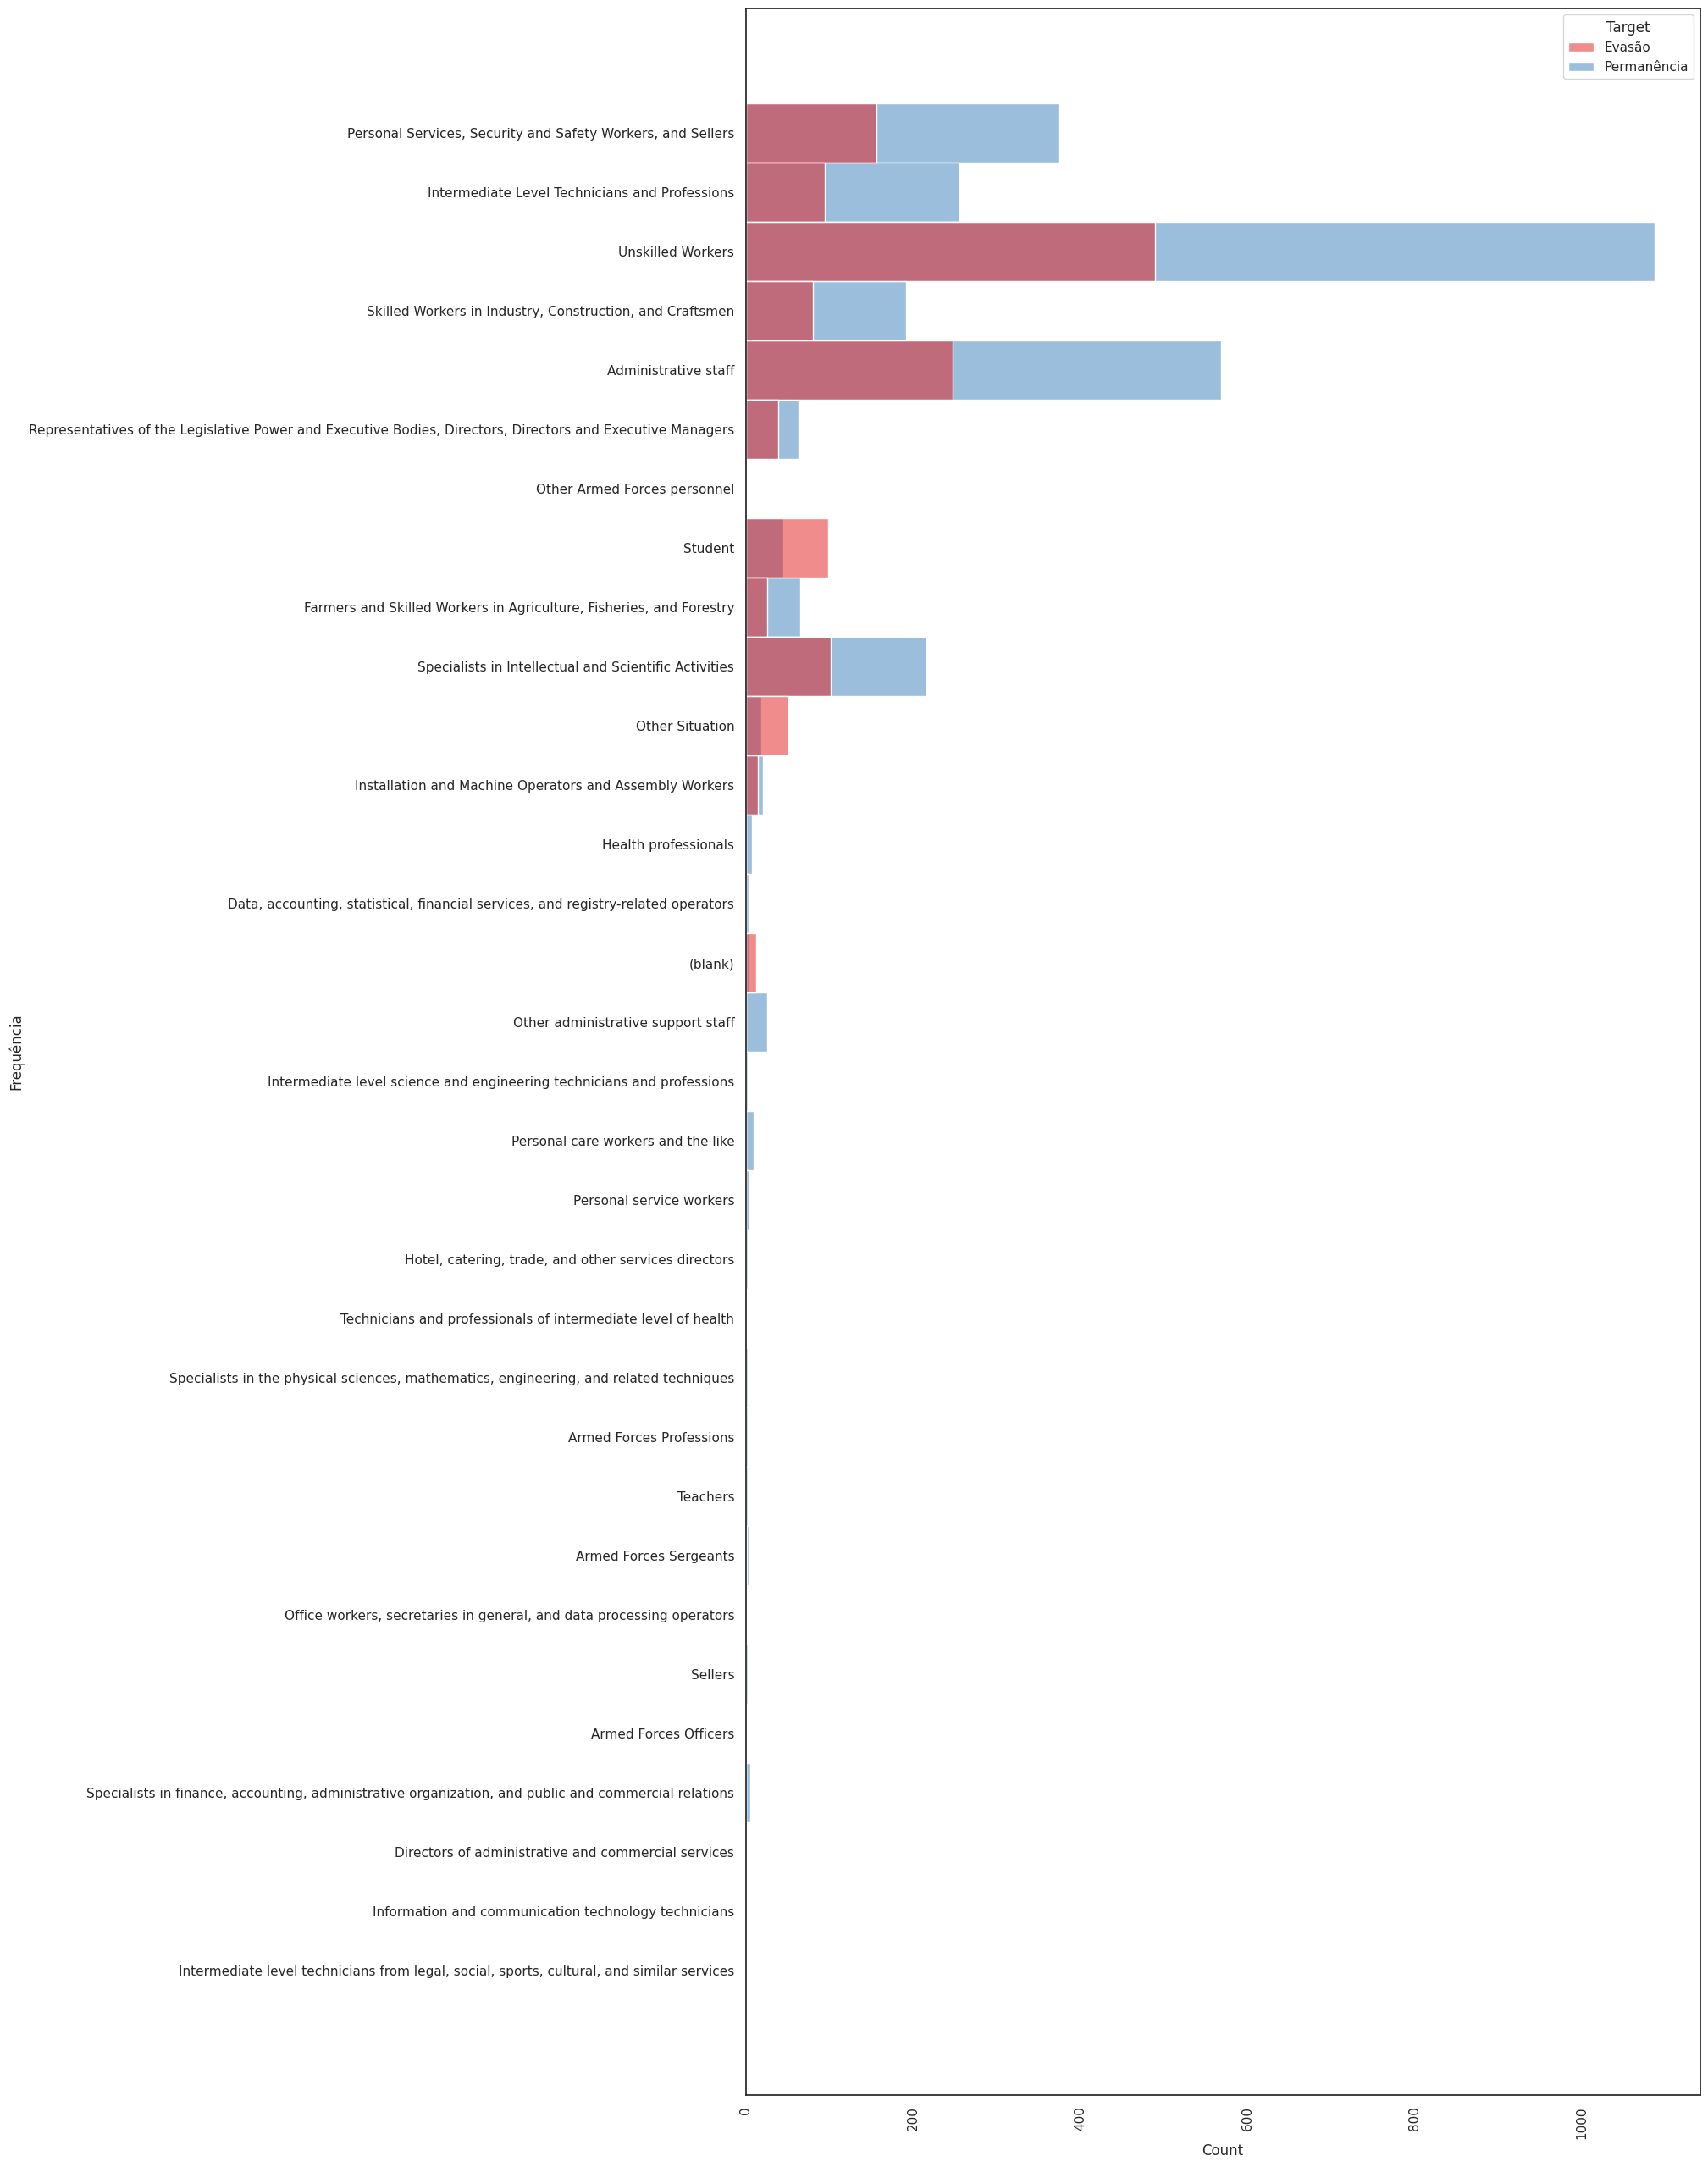

Father's occupation

Moda : 0    Unskilled Workers
Name: Father's occupation, dtype: object
Amostras únicas : 46
Amostras faltando : 0


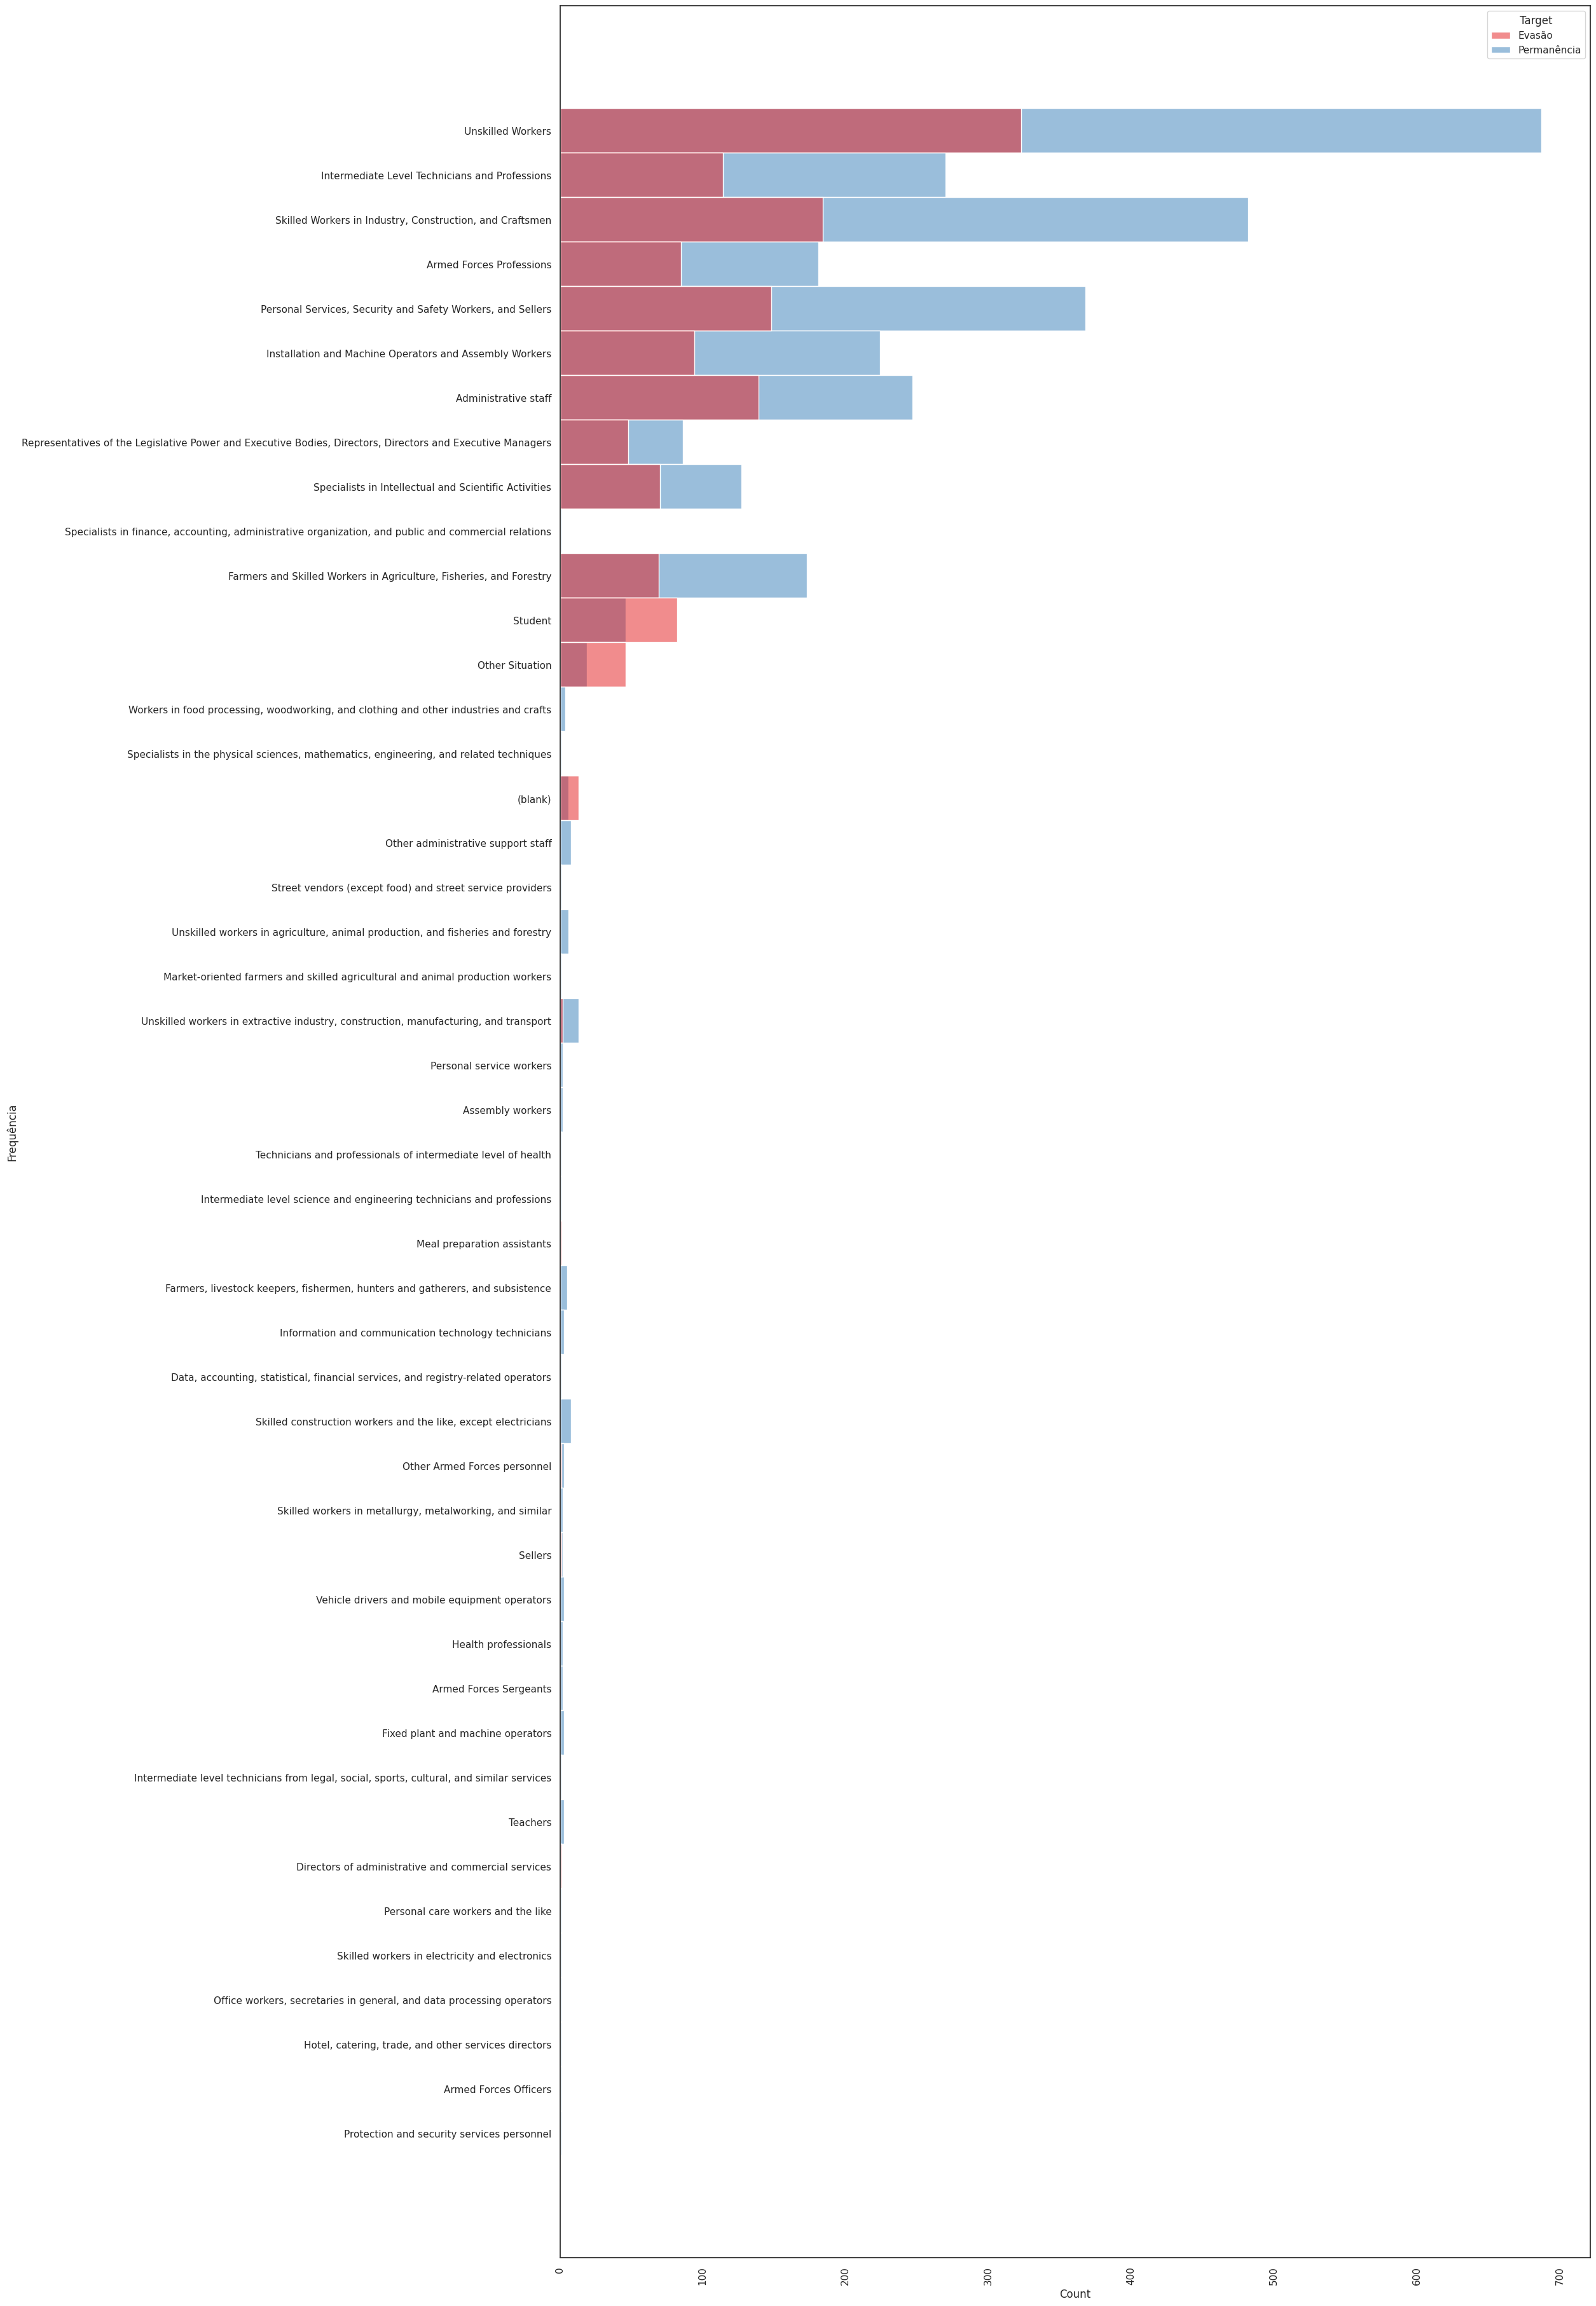

Marital status

Moda : 0    Single
Name: Marital status, dtype: object
Amostras únicas : 6
Amostras faltando : 0


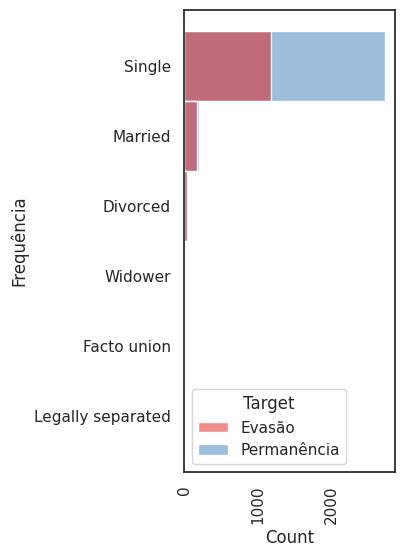

Daytime/evening attendance

Moda : 0    daytime
Name: Daytime/evening attendance, dtype: object
Amostras únicas : 2
Amostras faltando : 0


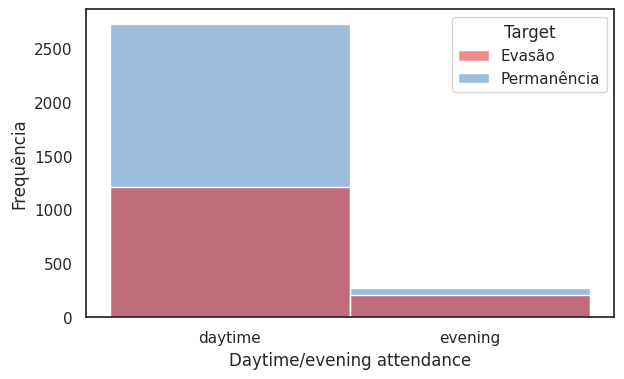

Displaced

Moda : 0    yes
Name: Displaced, dtype: object
Amostras únicas : 2
Amostras faltando : 0


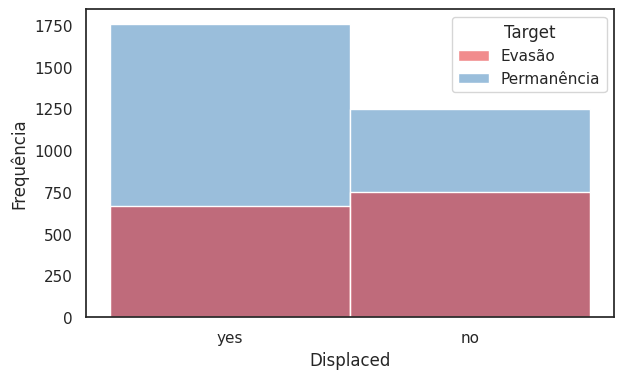

Gender

Moda : 0    female
Name: Gender, dtype: object
Amostras únicas : 2
Amostras faltando : 0


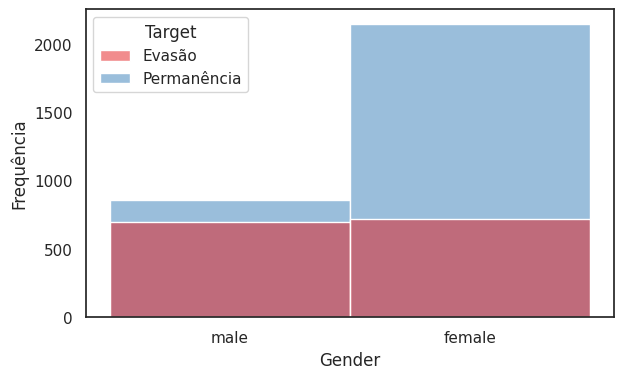

International

Moda : 0    no
Name: International, dtype: object
Amostras únicas : 2
Amostras faltando : 0


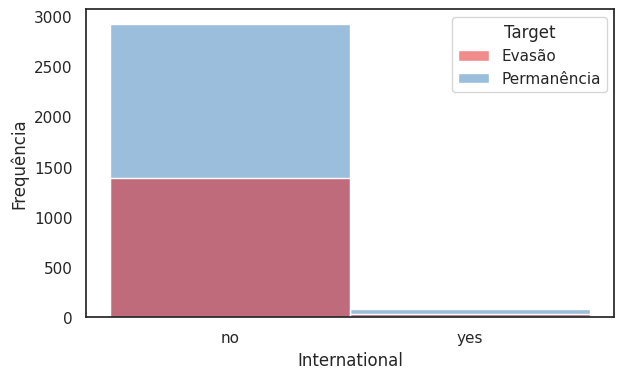

Educational special needs

Moda : 0    no
Name: Educational special needs, dtype: object
Amostras únicas : 2
Amostras faltando : 0


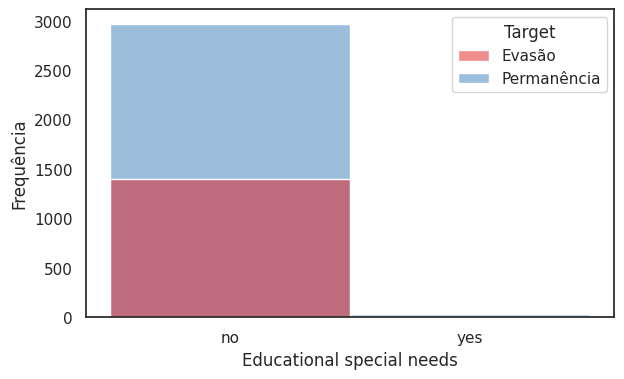

Debtor

Moda : 0    no
Name: Debtor, dtype: object
Amostras únicas : 2
Amostras faltando : 0


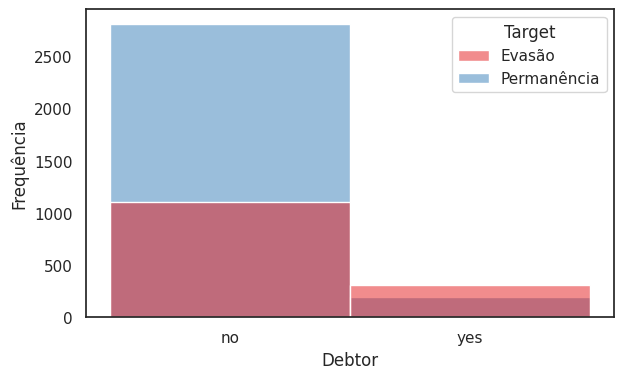

Tuition fees up to date

Moda : 0    yes
Name: Tuition fees up to date, dtype: object
Amostras únicas : 2
Amostras faltando : 0


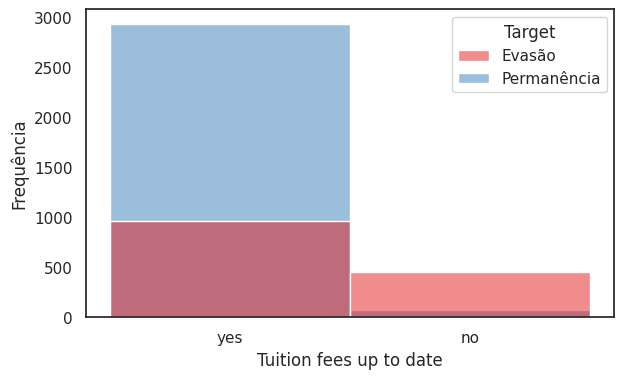

Scholarship holder

Moda : 0    no
Name: Scholarship holder, dtype: object
Amostras únicas : 2
Amostras faltando : 0


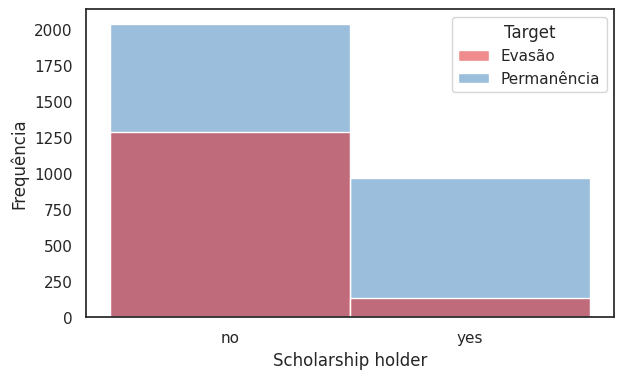

Target

Moda : 0    Permanência
Name: Target, dtype: object
Amostras únicas : 2
Amostras faltando : 0


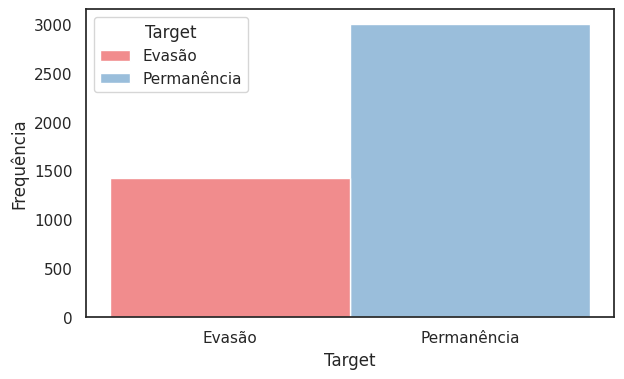

In [818]:
# Referência: https://www.analyticsvidhya.com/blog/2022/07/step-by-step-exploratory-data-analysis-eda-using-python/

for col in categorical_data:
    
    # Atributo
    print(col, end="\n\n")

    # Estatísticas descritivas
    print('Moda :', round(data_cat[col].mode(), 2))
    print('Amostras únicas :', data_cat[col].nunique())
    print('Amostras faltando :', data_cat[col].isnull().sum())

    num_labels = data_cat[col].nunique()

    if num_labels >= 5:

        width = max(5, num_labels)
        height = max(5, num_labels)

        plt.figure(figsize=(width, height))
        plt.subplot(1, 2, 1)
        sns.histplot(data=data_cat, y=col, kde=False, hue='Target', palette='Set1')
        plt.xticks(rotation=90)
        plt.ylabel('Frequência')
        plt.show()

    else:
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(data=data_cat, x=col, kde=False, hue='Target', palette='Set1')
        plt.ylabel('Frequência')
        plt.show()

## P4. Quais os padrões e anomalias entre todos os atributos?

- **Análise bivariada** quais as relações entre pares de atributos?

Target        Evasão  Permanência
Nacionality                      
Angolan          1.0          1.0
Brazilian       14.0         24.0
Cape Verdean     4.0          9.0
Colombian        1.0          0.0
Cuban            0.0          1.0


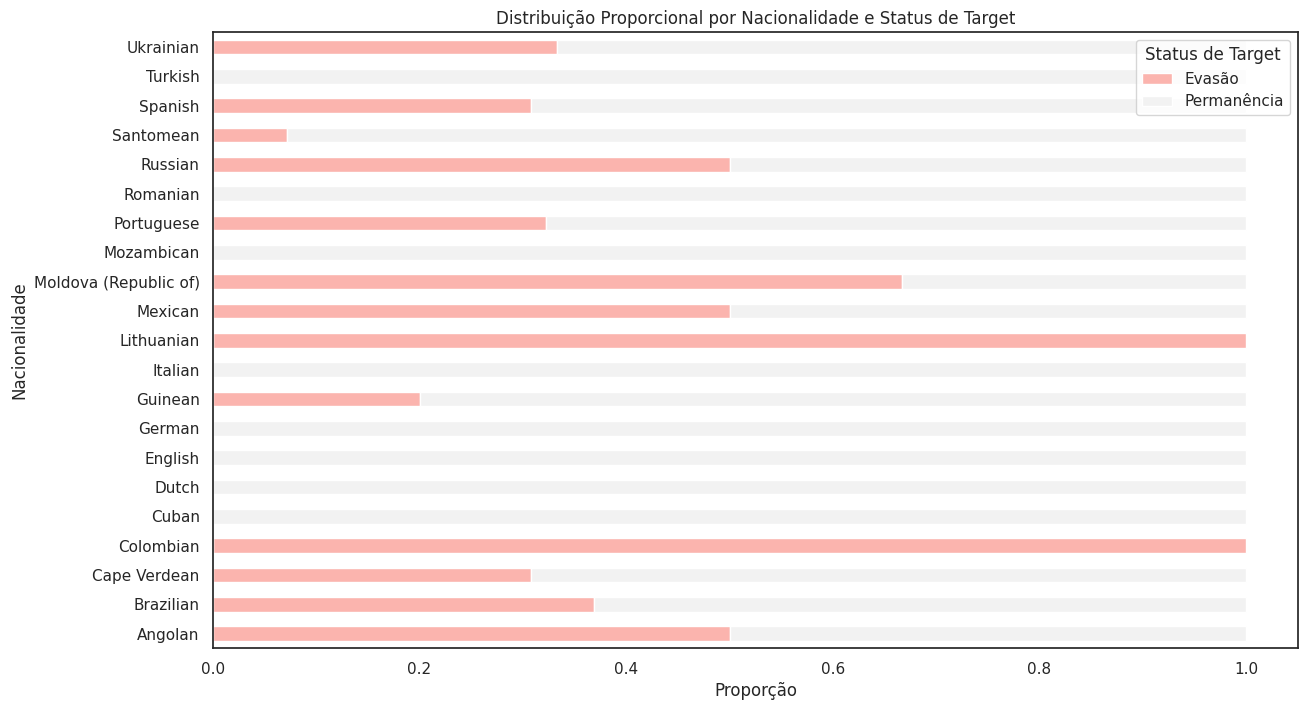

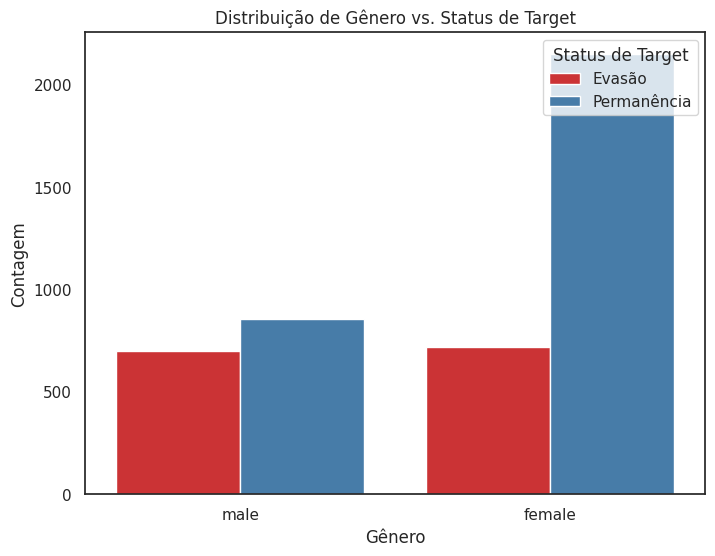

/tmp/ipykernel_16959/3531639920.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_cat, x='Target', y='Age at enrollment', palette='Set1')


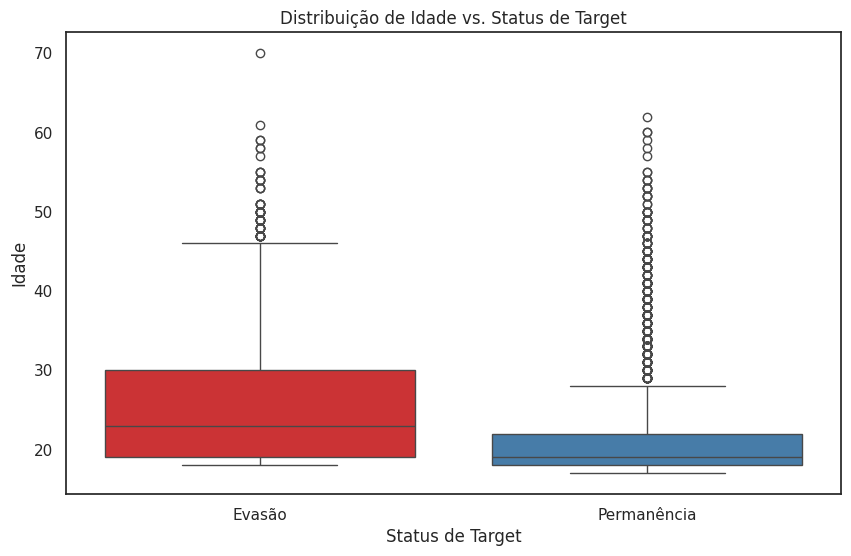

In [819]:
# Agrupando os dados por Nacionalidade e Status de Target
stacked_data = data_cat.groupby(['Nacionality', 'Target']).size().unstack().fillna(0)

# Normalizando os dados para mostrar proporções em vez de contagens absolutas
normalized_data = stacked_data.div(stacked_data.sum(axis=1), axis=0)

print(stacked_data.head())

# Criando o gráfico de barras empilhadas normalizado
normalized_data.plot(kind='barh', stacked=True, figsize=(14, 8), colormap='Pastel1')

plt.title('Distribuição Proporcional por Nacionalidade e Status de Target')
plt.xlabel('Proporção')
plt.ylabel('Nacionalidade')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Gráfico de Distribuição de Gênero vs. Status de Target
plt.figure(figsize=(8, 6))
sns.countplot(x='Gender', hue='Target', data=data_cat, palette='Set1')
plt.title('Distribuição de Gênero vs. Status de Target')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.legend(title='Status de Target', loc='upper right')
plt.show()

# Idade
plt.figure(figsize=(10, 6))
sns.boxplot(data=data_cat, x='Target', y='Age at enrollment', palette='Set1')
plt.title('Distribuição de Idade vs. Status de Target')
plt.xlabel('Status de Target')
plt.ylabel('Idade')
plt.show()

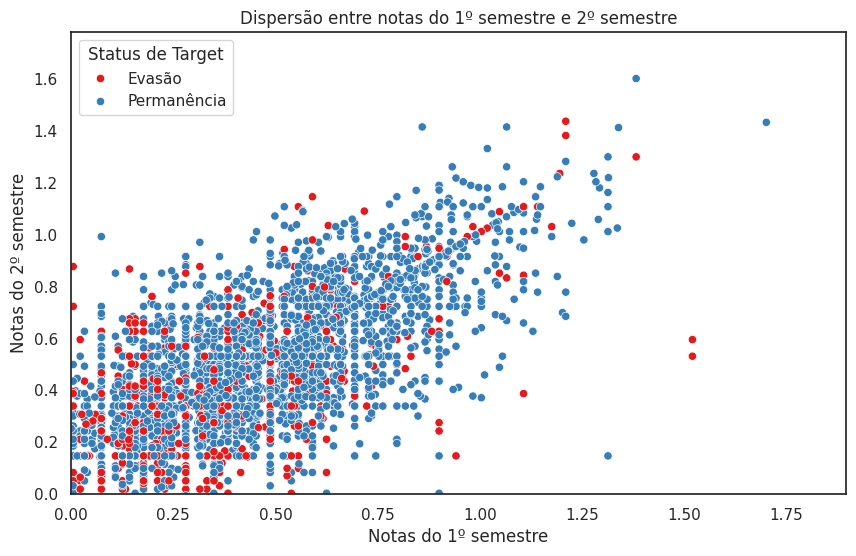

In [820]:
from sklearn.preprocessing import StandardScaler

# Normalize the data for x and y
scaler = StandardScaler()

# Create an empty DataFrame
normalized_df = pd.DataFrame()

normalized_df[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']] = scaler.fit_transform(data[['Curricular units 1st sem (grade)', 'Curricular units 2nd sem (grade)']])
normalized_df['Target'] = data['Target']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=normalized_df, x='Curricular units 1st sem (grade)', y='Curricular units 2nd sem (grade)', hue='Target', palette='Set1')
plt.title('Dispersão entre notas do 1º semestre e 2º semestre')
plt.xlabel('Notas do 1º semestre')
plt.ylabel('Notas do 2º semestre')
plt.legend(title='Status de Target', loc='upper left')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

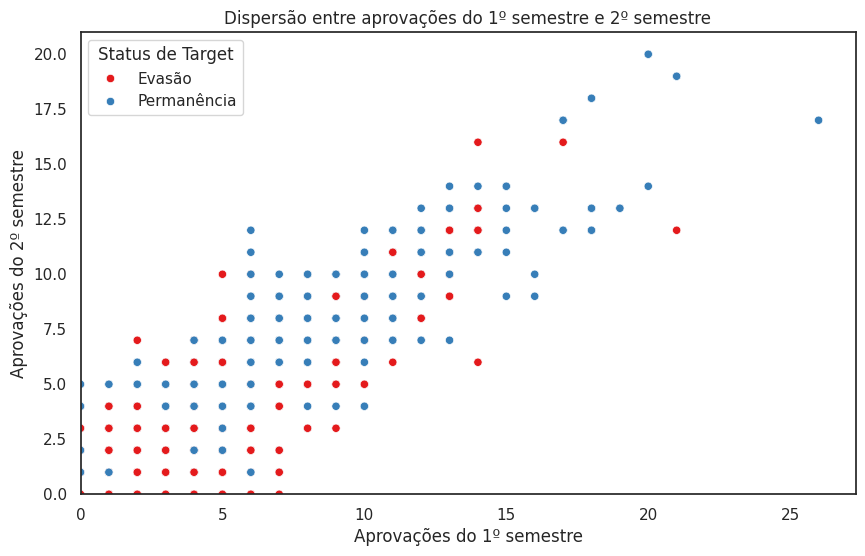

In [821]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Curricular units 1st sem (approved)', y='Curricular units 2nd sem (approved)', hue='Target', palette='Set1')
plt.title('Dispersão entre aprovações do 1º semestre e 2º semestre')
plt.xlabel('Aprovações do 1º semestre')
plt.ylabel('Aprovações do 2º semestre')
plt.legend(title='Status de Target', loc='upper left')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

- **Análise multivariada**: quais as relações entre as variáveis numéricas e categóricas?

Para podermos comparar variáveis numéricas e categóricas, precisamos mapear as strings categóricas para atributos numéricos. Como neste dataset, originalmente, as variáveis categóricas já estão mapeadas em valores numéricos discretos, precisamos apenas mapear o atributo alvo.

In [822]:
# Podemos mudar essas strings para valores int
# Label encoding
data['Target'] = data['Target'].map({
    'Evasão':1,
    'Permanência':0
})

print(data["Target"].unique())

[1 0]


Com isto, avaliamos quais fatores influenciam diretamente a desistência dos alunos através do método de correlação de Pearson. Queremos visualizar a correlação entre os atributos. Para isto, criamos uma matriz de correlação diagonal.

In [823]:
attribute_corr = data.corr(method = 'pearson') # Gera uma matriz de correlação e mostra apenas as correlações entre o Target e outras variáveis

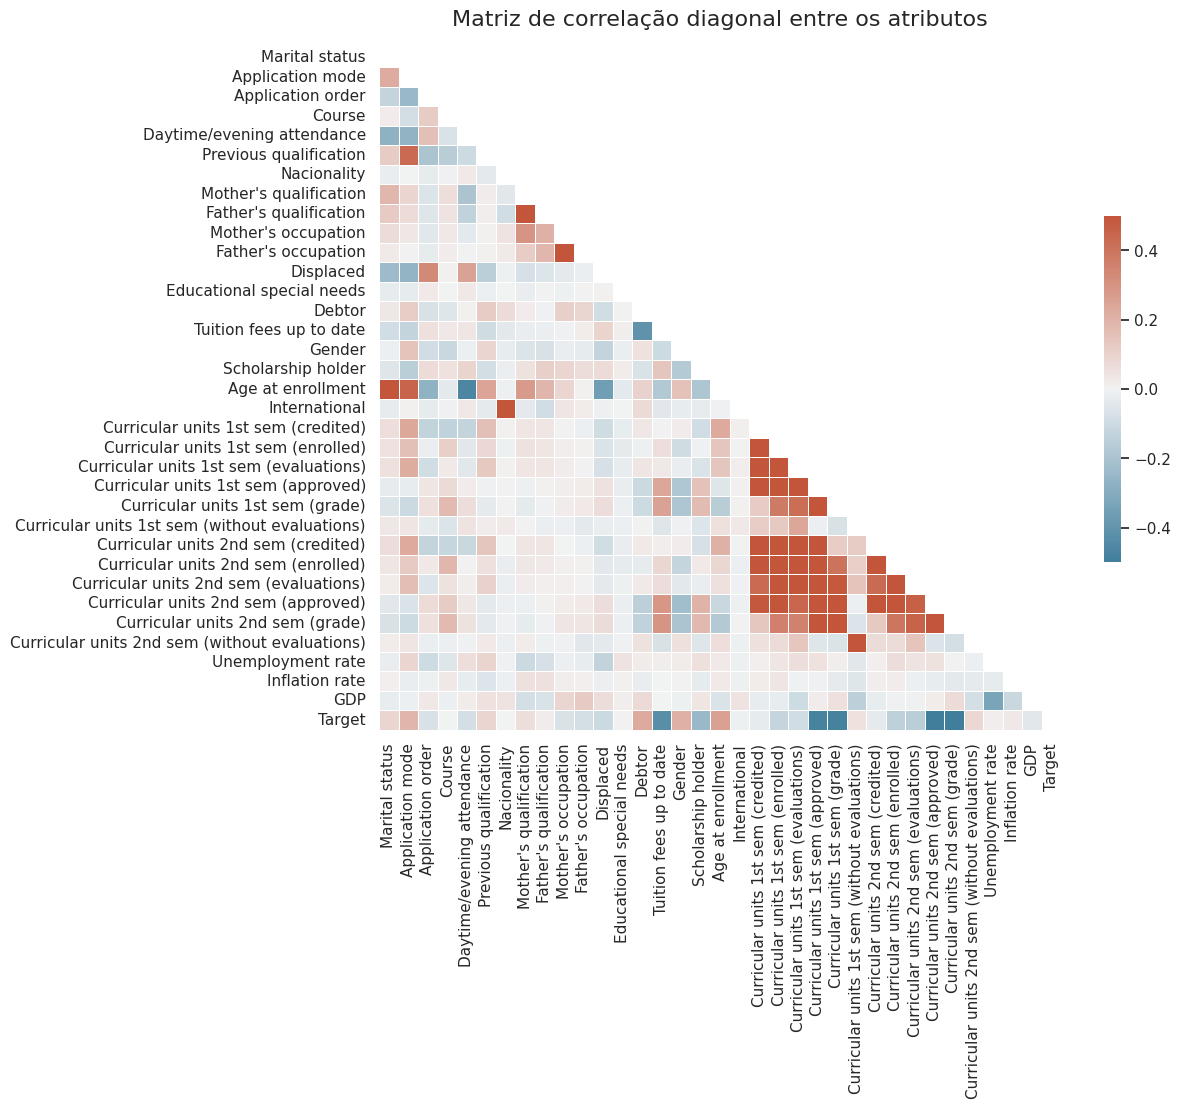

In [824]:
# Plotting a diagonal correlation matrix: https://seaborn.pydata.org/examples/many_pairwise_correlations.html

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(attribute_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
diag_heatmap = sns.heatmap(attribute_corr, mask=mask, cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

diag_heatmap.set_title('Matriz de correlação diagonal entre os atributos', fontdict={'fontsize':16}, pad=16);

- Existem atributos redundantes, como International e Nacionality, que têm correlação considerável entre si
- Outras correlações significativas são óbvias, e poderiam ser úteis apenas para resumir dois atributos em um, se forem selecionados:
  - Age at enrollment vs Marital status
  - Age at enrollment vs Application mode
  - Mother's occupation vs Father's occupation
  - Mother's qualification vs Father's qualification
  - Curricular units 1st sem vs Curricular units 2nd sem

# 3. Pré-processamento dos dados

Aplique técnicas de pré-processamento nos dados a fim de melhorar a qualidade dos mesmos por meio da eliminação ou minimização de problemas identificados na etapa anterior. A avaliação deste trabalho não exigirá um pré-processamento aprofundado, por ser um tópico ainda pouco discutido na disciplina, mas será esperado que os grupos lidem com aspectos como a remoção de atributos ou instâncias problemáticas (por exemplo, por conterem muitos valores faltantes ou não parecerem informativas para o problema), normalização de atributos, balanceamento de classes, transformação de atributos de categórico para numérico, caso se mostrem necessários nos dados escolhidos.

- Remoção de atributos ou instâncias problemáticas
- Balanceamento de classes
- Transformação de atributos
- Normalização de atributos

## Remoção de atributos ou instâncias problemáticas

Na fase de EDA, identificamos instâncias discrepantes (outliers) em alguns atributos. Porém, nenhum se trata de valores inconsistentes ou erros:

- Grade 1st
- Grade 2nd
- Unemployment rate
- Inflation rate
- GDP

Para a seleção de atributos, escolhemos a abordagem baseada em filtros, utilizando  a correlação de Pearson como métrica. Critérios mais avançados podem ser utilizados posteriormente, como aplicados em [1].

                                                  Target
Target                                          1.000000
Age at enrollment                               0.254215
Debtor                                          0.229407
Gender                                          0.203983
Application mode                                0.188908
Marital status                                  0.093712
Previous qualification                          0.091590
Curricular units 2nd sem (without evaluations)  0.079901
Mother's qualification                          0.059499
Curricular units 1st sem (without evaluations)  0.054230
Inflation rate                                  0.027826
Father's qualification                          0.016267
Unemployment rate                               0.012980
Educational special needs                       0.002806
Course                                         -0.000083
Nacionality                                    -0.001571
International                  

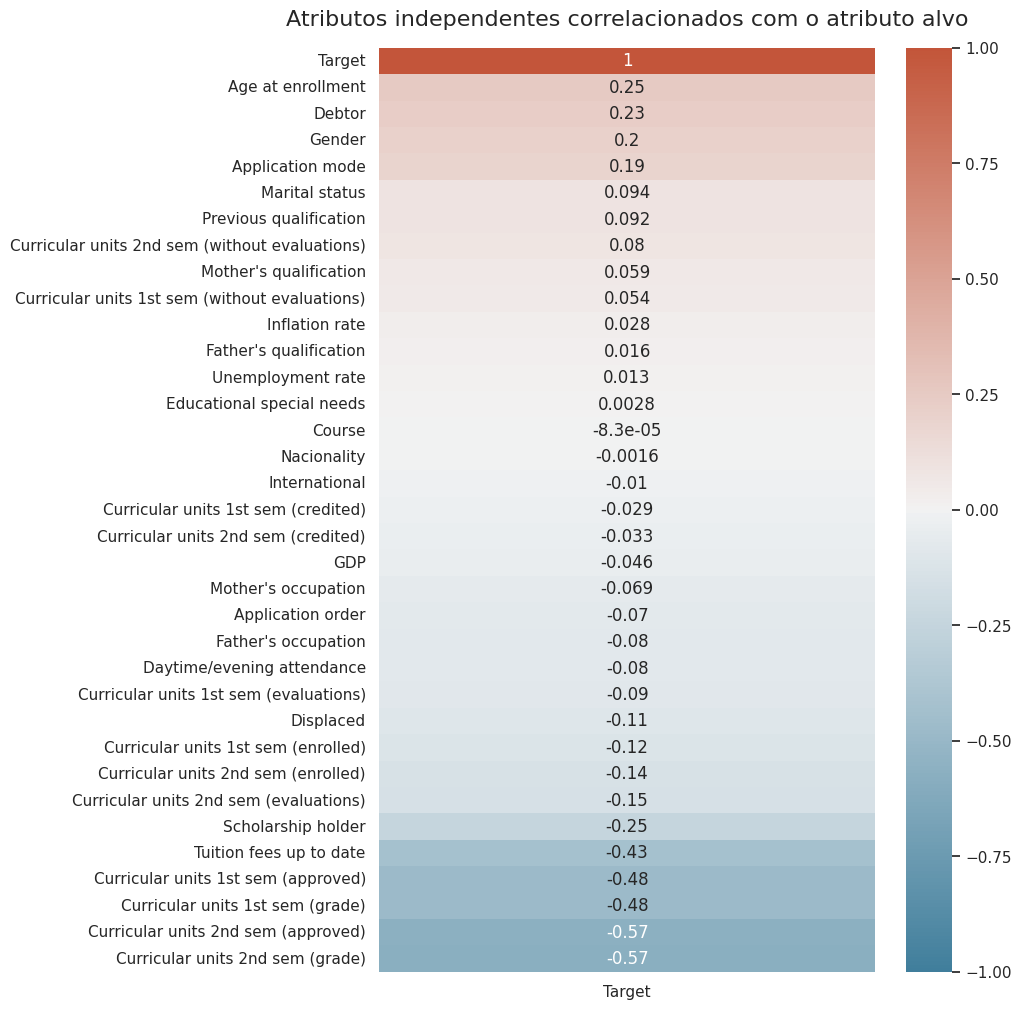

In [825]:
# https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

attr_corr_target = data.corr()[['Target']].sort_values(by='Target', ascending=False)

print(attr_corr_target)

plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=cmap)
heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16);

A classificação da correlação de Pearson pode entre diferentes autores e domínios. Podemos interpretar as correlações da seguinte maneira:

Interpretação convencional: https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx

| Coeficiente de correlação | Interpretação |
|----------------------|-------------|
| Muito forte       | 0.90 - 1.0      |
| Forte             | 0.70 - 0.89     |
| Moderada          | 0.40 - 0.69     |
| Fraca             | 0.10 - 0.39     |
| Desconsiderável   | 0.00 - 0.10     |


**Moderadas:**
- Tuition fees up to date                        -0.429149
- Curricular units 1st sem (approved)            -0.479112
- Curricular units 1st sem (grade)               -0.480669
- Curricular units 2nd sem (approved)            -0.569500
- Curricular units 2nd sem (grade)               -0.571792

**Fracas:**
- Age at enrollment                               0.254215
- Debtor                                          0.229407
- Gender                                          0.203983
- Application mode                                0.188908
- Displaced                                      -0.107232
- Curricular units 1st sem (enrolled)            -0.124635
- Curricular units 2nd sem (enrolled)            -0.141515
- Curricular units 2nd sem (evaluations)         -0.154999
- Scholarship holder                             -0.245354

**Desprezíveis:**
- Marital status                                  0.093712
- Previous qualification                          0.091590
- Curricular units 2nd sem (without evaluations)  0.079901
- Mother's qualification                          0.059499
- Curricular units 1st sem (without evaluations)  0.054230
- Inflation rate                                  0.027826
- Father's qualification                          0.016267
- Unemployment rate                               0.012980
- Educational special needs                       0.002806
- Course                                         -0.000083
- Nacionality                                    -0.001571
- International                                  -0.010360
- Curricular units 1st sem (credited)            -0.029308
- Curricular units 2nd sem (credited)            -0.033038
- GDP                                            -0.046319
- Mother's occupation                            -0.069102
- Application order                              -0.070485
- Father's occupation                            -0.079753
- Daytime/evening attendance                     -0.080499
- Curricular units 1st sem (evaluations)         -0.090125


Nesta análise, 20 dos 34 atributos mostraram correlação desprezível com o atributo alvo. Já os 9 atributos restantes apresentaram correlação fraca e 5 atributos correlação moderada.

Para seleção dos atributos baseada em filtros, adotamos a abordagem baseada em threshold, que é um valor mínimo de correlação pré-definida experimentalmente. Adotamos o score experimental 0.25, para selecionar apenas os atributos de correlação moderada e um atributo com correlação fraca, mas mais próximo do limiar para moderada. Este score pode ser revisitado após o treinamento do modelo preditivo, e pode ser ajustado para testar novos atributos.

In [826]:
# Filtra atributos com correlação com Target > 0.25
strong_pos_corr = attr_corr_target[attr_corr_target.gt(0.25).any(axis=1)]
strong_pos_corr.index.tolist()

strong_neg_corr = attr_corr_target[attr_corr_target.lt(-0.25).any(axis=1)]
strong_neg_corr.index.tolist()

strong_corr = pd.concat([strong_pos_corr, strong_neg_corr])

strong_corr

,Target
Target,1.000000
Age at enrollment,0.254215
Tuition fees up to date,-0.429149
Curricular units 1st sem (approved),-0.479112
Curricular units 1st sem (grade),-0.480669
Curricular units 2nd sem (approved),-0.569500
Curricular units 2nd sem (grade),-0.571792


In [827]:
new_attributes = strong_corr.index.tolist()

In [828]:
data = data[new_attributes]
data.head()

,Target,Age at enrollment,Tuition fees up to date,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade)
0,1,20,1,0,0.000000,0,0.000000
1,0,19,0,6,14.000000,6,13.666667
2,1,19,0,0,0.000000,0,0.000000
3,0,20,1,6,13.428571,5,12.400000
4,0,45,1,5,12.333333,6,13.000000


In [829]:
numerical_data = ['Age at enrollment',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)']

## Transformação de atributos

Com a seleção de atributos baseada em correlação com o alvo, não sobrou nenhuma coluna do tipo categórico binário para realizar transformação.

In [830]:
# data[categorical_nominal].head()

In [831]:
# # Perform one-hot encoding for columns in categorical_nominal
# data_encoded = pd.get_dummies(data, columns=categorical_nominal)

# # Display the first few rows of the encoded dataframe
# data_encoded.head()

One-hot encoding

In [832]:
# # https://medium.com/@szabo.bibor/how-to-create-a-seaborn-correlation-heatmap-in-python-834c0686b88e

# attr_corr_target = data_encoded.corr()[['Target']].sort_values(by='Target', ascending=False)

# print(attr_corr_target)

# plt.figure(figsize=(8, 50))
# heatmap = sns.heatmap(attr_corr_target, vmin=-1, vmax=1, annot=True, cmap=cmap)
# heatmap.set_title('Atributos independentes correlacionados com o atributo alvo', fontdict={'fontsize':16}, pad=16);

## Balanceamento de classes

Como observamos no EDA, temos um desbalanceamento entre as classes do atributo Target.

In [833]:
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import SMOTE

# # Separa atributos preditivos e atributo alvo
# X = data.drop('Target', axis=1)
# y = data['Target']

# print(y.value_counts())

# # Under sampling Randômico
# # Referência: https://imbalanced-learn.org/dev/under_sampling.html#

# rus = RandomUnderSampler(random_state=0, sampling_strategy='majority')
# X_resampled, y_resampled = rus.fit_resample(X, y)

# print(y_resampled.value_counts())

# # Realiza o SMOTE
# # Referência https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/

# smote = SMOTE(sampling_strategy='minority') 
# x,y = smote.fit_resample(X_resampled,y_resampled)
# y.value_counts()

In [834]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

print(y.value_counts())

# Realiza o SMOTE
# Referência https://www.geeksforgeeks.org/smote-for-imbalanced-classification-with-python/

smote = SMOTE(sampling_strategy='minority') 
x,y = smote.fit_resample(X,y)
y.value_counts()

Target
0    3003
1    1421
Name: count, dtype: int64


Target
1    3003
0    3003
Name: count, dtype: int64

In [835]:
data_resampled = pd.concat([x, y], axis=1)
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6006 entries, 0 to 6005
Data columns (total 7 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Age at enrollment                    6006 non-null   int64  
 1   Tuition fees up to date              6006 non-null   int64  
 2   Curricular units 1st sem (approved)  6006 non-null   int64  
 3   Curricular units 1st sem (grade)     6006 non-null   float64
 4   Curricular units 2nd sem (approved)  6006 non-null   int64  
 5   Curricular units 2nd sem (grade)     6006 non-null   float64
 6   Target                               6006 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 328.6 KB


## Normalização de atributos

Os dados numéricos deste dataset tem escalas bastante diferentes, como a ordem de aplicação, que é um atributo numérico ordinal, e as notas, que são atributos numéricos contínuos.

Os dados foram normalizados após o split, na seção [Spot-checking](#5-spot-checking), para não acontecer contaminação nos dados de teste pelas estimativas de média e desvio padrão.


In [836]:
data_resampled[numerical_data].head()

,Age at enrollment,Curricular units 1st sem (approved),Curricular units 1st sem (grade),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade)
0,20,0,0.000000,0,0.000000
1,19,6,14.000000,6,13.666667
2,19,0,0.000000,0,0.000000
3,20,6,13.428571,5,12.400000
4,45,5,12.333333,6,13.000000


Realizaremos uma normalização por min-max scaling e padronização por z-score. Porém, como o z-score estima a média e desvio padrão de cada atributo, isto pode significar um vazamento de dados ao realizar o split de dados após este processo.

# 4. Abordagem de aprendizado

Defina a abordagem de aprendizado de máquina que você planeja utilizar, isto é, se o problema é de classificação ou regressão. Justifique sua escolha com base na natureza do problema e nos dados disponíveis.
Selecione os algoritmos de aprendizado supervisionado a serem aplicados. Esta definição é de livre escolha do grupo, mas solicita-se que englobe algoritmos que constem no conteúdo programático da disciplina (podendo incluir de forma adicional outros algoritmos não abordados na disciplina).

Além disso, sugere-se selecionar um conjunto diversificado de algoritmos (em termos de viés indutivo), seguindo o propósito de spot-checking. Neste trabalho prático, os algoritmos podem ser aplicados como valores padrões de hiperparâmetros ou, se for a vontade do grupo, com uma variação mínima nos mesmos (como por exemplo, uma árvore de decisão sem poda e com uma poda não muito drástica). Os grupos devem comparar ao menos 5 algoritmos distintos.

Selecione as métricas de desempenho que serão usadas para avaliar os modelos a partir da definição da modelagem e da interpretação do problema a ser abordado. Neste processo, é recomendado utilizar mais de uma métrica para avaliação e comparação de modelos, mas selecionar uma métrica como critério principal de seleção de modelos (ou seja, aquela que o grupo tentará otimizar na análise de desempenho dos algoritmos). Escolha, também, a estratégia que aplicará para realizar a divisão de dados para treinamento e avaliação (holdout, cross-validation, etc..)

In [837]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

# Métricas
def get_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, f1, precision, recall


In [838]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Padronização', StandardScaler()))
    steps.append(('Normalização', MinMaxScaler()))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

In [839]:
metrics_df = pd.DataFrame(columns=['Algoritmo', 'Fold', 'Acurácia'])

In [840]:
from sklearn.model_selection import cross_val_score

X = data_resampled.drop('Target', axis=1)
y = data_resampled['Target']

# Realiza a validação cruzada de um modelo, dado o número de folds e a métrica
def evaluate_model(X, y, algorithm, folds, metric):
    pipeline = make_pipeline(algorithm)
    scores = cross_val_score(pipeline, X, y, cv=folds, n_jobs=-1,
                            scoring=metric)

    return scores

# 5. Spot-checking

Execute a verificação rápida dos algoritmos através do treinamento e avaliação dos modelos de acordo com as definições do item anterior. Testar uma variedade de algoritmos permite que se possa identificar quais modelos têm o melhor desempenho inicial com os dados disponíveis. Isso economiza tempo e esforço ao focar em algoritmos que realmente têm potencial.
Recomenda-se a execução de múltiplas repetições do treinamento e avaliação usando cada algoritmo selecionado. É importante garantir a consistência dos resultados utilizando as mesmas divisões de dados em em uma determinada iteração para todos os algoritmos. Também é recomendado utilizar a definição manual de seeds em processos aleatórios (parâmetro random_state, no scikit-learn), para fins de reprodutibilidade dos experimentos. Lembre-se que neste trabalho prático não estamos interessados em realizar a otimização de hiperparâmetros ou a análise aprofundada dos modelos, como interpretabilidade dos mesmos.

Faça a sumarização dos resultados da avaliação dos modelos. O objetivo desta sumarização é identificar quais algoritmos se saíram melhor e merecem seguir para uma investigação mais detalhada, fazendo uma escolha informada de algoritmos para otimização de modelos. Atenção: esta investigação está fora do escopo do T1.
Para esta etapa, sugere-se o uso de sumarização por média e desvio padrão do desempenho, bem como gráficos do tipo box plot, violin plot, joy plot, etc, para visualização da distribuição de desempenho por modelo ao longo de n execuções. O uso de gráficos é importante pois viabiliza uma análise visual dos resultados.

In [846]:
def evaluate_models(X, y, models, metrics_df, folds=10, metric='accuracy'):
    results = dict()

    for name, model in models.items():

        scores = evaluate_model(X, y, model, folds, metric)

        for i, score in enumerate(scores):
            series = pd.Series({'Algoritmo': name, 'Fold': i, 'Acurácia': score})
            metrics_df = pd.concat([metrics_df, series.to_frame().T], ignore_index=True)

        if scores is not None:
            results[name] = scores
            mean_score, std_score = np.mean(scores), np.std(scores)

            print(f'{name}: {mean_score:.3f} ({std_score:.3f})')
        else:
            print(f'{name}: Erro ao calcular a pontuação')

    return results, metrics_df

results, metrics_df = evaluate_models(X,y, algo_dict, metrics_df)

Decision Tree: 0.830 (0.023)
Decision Tree Max depth 5: 0.832 (0.022)
Random Forest gini: 0.873 (0.029)
Random Forest entropy: 0.873 (0.031)
Logistic Regression: 0.833 (0.023)
3-Nearest Neighbors: 0.826 (0.026)
5-Nearest Neighbors: 0.840 (0.020)
AdaBoost: 0.840 (0.020)
SVM: 0.813 (0.024)


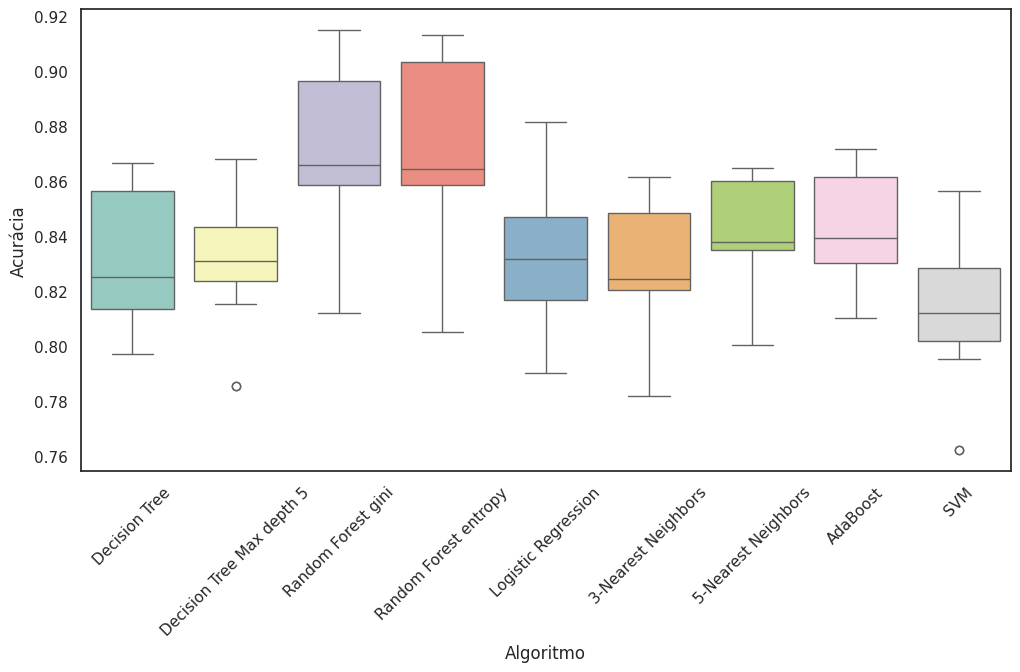

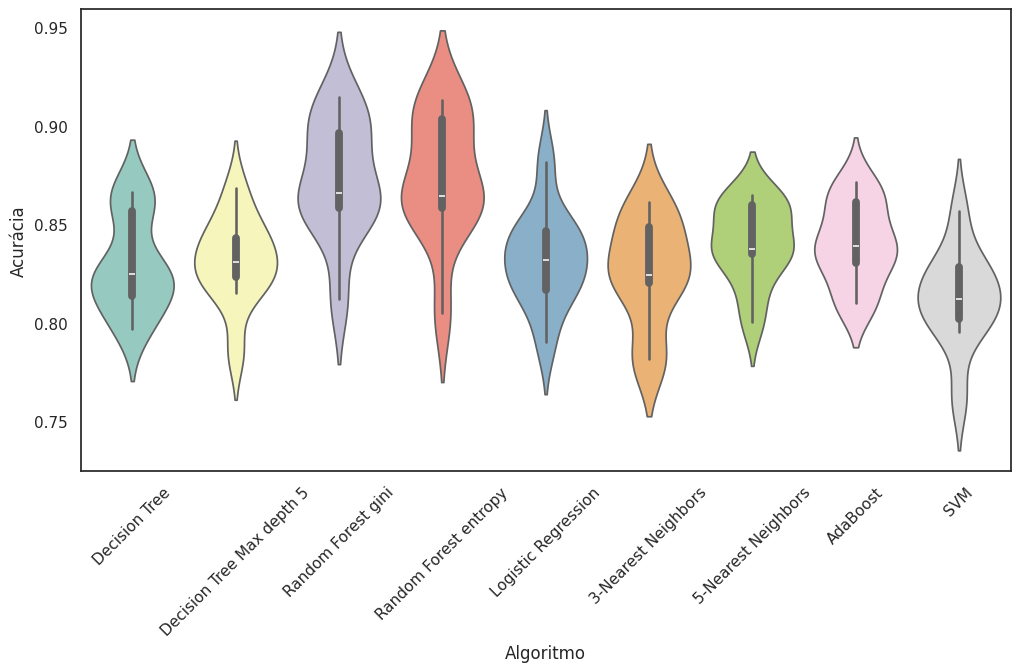

In [848]:
# boxplot for the top n
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Algoritmo', y='Acurácia', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=metrics_df, x='Algoritmo', y='Acurácia', hue='Algoritmo', palette='Set3')
plt.xticks(rotation=45)
plt.show()

Joy plot com joypy

<Figure size 1900x1200 with 0 Axes>

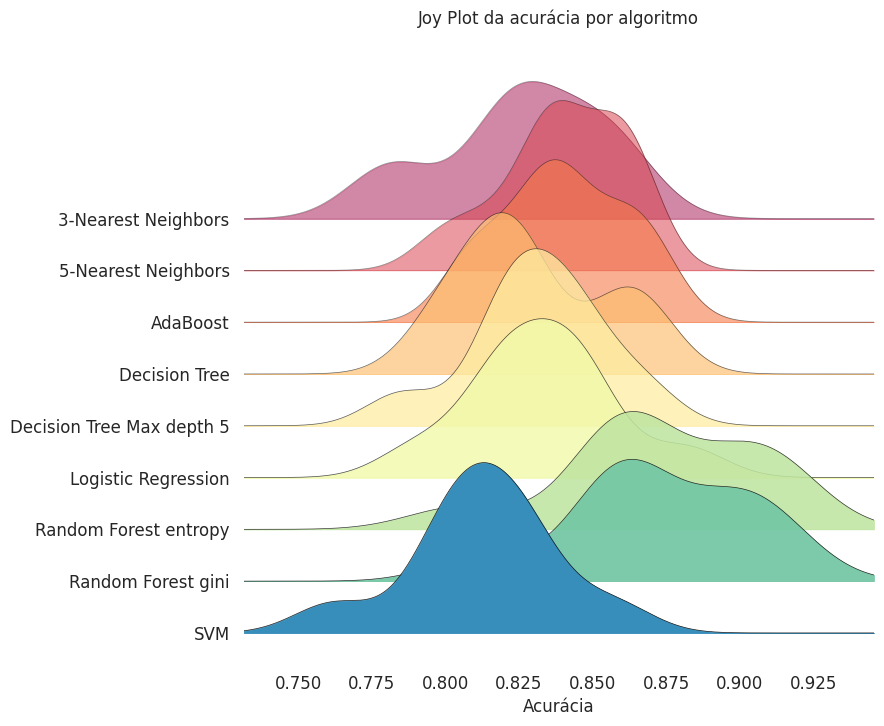

In [850]:
#https://github.com/leotac/joypy/blob/master/Joyplot.ipynb

import joypy
import matplotlib.pyplot as plt

# Ensure 'Acurácia' column is numeric
metrics_df['Acurácia'] = pd.to_numeric(metrics_df['Acurácia'], errors='coerce')

# Prepare the data for the joy plot
data_for_joyplot = metrics_df.pivot(columns='Algoritmo', values='Acurácia')

plt.figure(figsize=(19, 12))
joypy.joyplot(data_for_joyplot, colormap=plt.cm.Spectral, overlap=2, fade=True, linewidth=.5, figsize=(9,7))

plt.title('Joy Plot da acurácia por algoritmo')
plt.xlabel('Acurácia')
plt.show()